In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import polars as pl
import gc
import os
import time
from datetime import timedelta
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
gc.collect()

20

# Data preperation

In [3]:
probka = pl.read_csv('.\\danonki\\1472_all_confidence.csv', n_rows=50, ignore_errors=True)
kolumny = probka.columns
reference_schema = probka.schema

def cast_to_reference_schema_special(df, reference_schema):
    return df.with_columns([
        # Jeśli docelowy typ to Int64, wykonaj najpierw cast na Float64, a potem na Int64
        pl.col(col_name).cast(pl.Float64).cast(pl.Int64) if reference_schema[col_name] == pl.Int64 
        else pl.col(col_name).cast(reference_schema[col_name])  # Dla pozostałych kolumn wykonaj zwykłe rzutowanie
        for col_name in df.columns if col_name in reference_schema
    ])


folder_path = '.\\danonki'
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# Lista przechowująca przetworzone ramki danych
dane_lazy_frames = []
 
#Przetwarzanie plików
for i, path in enumerate(file_paths):
    print(f"Przetwarzanie pliku {i + 1}/{len(file_paths)}: {path}")

    # Lazy load ramki z rzutowaniem
    dane_lazy = (
        pl.scan_csv(path, ignore_errors=True)
    )

    dane_lazy = cast_to_reference_schema_special(dane_lazy, reference_schema)
 
    dane_lazy_frames.append(dane_lazy)

# Konkatenacja wszystkich ramek danych
dane_combined_lazy = pl.concat(dane_lazy_frames, how="vertical")

# Zmaterializowanie połączonych danych
final_data = dane_combined_lazy.collect()

Przetwarzanie pliku 1/12: .\danonki\1472_all_confidence.csv
Przetwarzanie pliku 2/12: .\danonki\2004_data_confidence.csv
Przetwarzanie pliku 3/12: .\danonki\2500_data_confidence.csv
Przetwarzanie pliku 4/12: .\danonki\2582_all_confidence.csv
Przetwarzanie pliku 5/12: .\danonki\3839_data_confidence.csv
Przetwarzanie pliku 6/12: .\danonki\4614_data_confidence.csv
Przetwarzanie pliku 7/12: .\danonki\4953_data_confidence.csv
Przetwarzanie pliku 8/12: .\danonki\5656_data_confidence.csv
Przetwarzanie pliku 9/12: .\danonki\6139_data_confidence.csv
Przetwarzanie pliku 10/12: .\danonki\6241_data_confidence.csv
Przetwarzanie pliku 11/12: .\danonki\6601_data_confidence.csv
Przetwarzanie pliku 12/12: .\danonki\7501_data_confidence.csv


C:\Users\user\AppData\Local\Temp\ipykernel_14828\1905424641.py:10: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  for col_name in df.columns if col_name in reference_schema


In [4]:
time.sleep(4)

In [5]:
probka = pl.read_csv('.\\danonki\\1472_all_confidence.csv', n_rows=50, ignore_errors=True)
kolumny = probka.columns
reference_schema = probka.schema

def cast_to_reference_schema_special(df, reference_schema):
    return df.with_columns([
        # Jeśli docelowy typ to Int64, wykonaj najpierw cast na Float64, a potem na Int64
        pl.col(col_name).cast(pl.Float64).cast(pl.Int64) if reference_schema[col_name] == pl.Int64 
        else pl.col(col_name).cast(reference_schema[col_name])  # Dla pozostałych kolumn wykonaj zwykłe rzutowanie
        for col_name in df.columns if col_name in reference_schema
    ])


folder_path = '.\\danonki2'
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# Lista przechowująca przetworzone ramki danych
dane_lazy_frames = []
 
#Przetwarzanie plików
for i, path in enumerate(file_paths):
    print(f"Przetwarzanie pliku {i + 1}/{len(file_paths)}: {path}")

    # Lazy load ramki z rzutowaniem
    dane_lazy = (
        pl.scan_csv(path, ignore_errors=True)
    )

    dane_lazy = cast_to_reference_schema_special(dane_lazy, reference_schema)
 
    dane_lazy_frames.append(dane_lazy)

# Konkatenacja wszystkich ramek danych
dane_combined_lazy2 = pl.concat(dane_lazy_frames, how="vertical")

# Zmaterializowanie połączonych danych
final_data2 = dane_combined_lazy2.collect()

Przetwarzanie pliku 1/11: .\danonki2\0681_data_confidence.csv
Przetwarzanie pliku 2/11: .\danonki2\1153_data_confidence.csv
Przetwarzanie pliku 3/11: .\danonki2\1981_all_confidence.csv
Przetwarzanie pliku 4/11: .\danonki2\6754_data_confidence.csv
Przetwarzanie pliku 5/11: .\danonki2\7297_data_confidence.csv
Przetwarzanie pliku 6/11: .\danonki2\7379_data_confidence.csv
Przetwarzanie pliku 7/11: .\danonki2\8193_data_confidence.csv
Przetwarzanie pliku 8/11: .\danonki2\8281_data_confidence.csv
Przetwarzanie pliku 9/11: .\danonki2\8779_data_confidence.csv
Przetwarzanie pliku 10/11: .\danonki2\8866_data_confidence.csv
Przetwarzanie pliku 11/11: .\danonki2\9813_data_confidence.csv


C:\Users\user\AppData\Local\Temp\ipykernel_14828\959448906.py:10: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  for col_name in df.columns if col_name in reference_schema


In [6]:
del dane_combined_lazy, dane_combined_lazy2 , dane_lazy, dane_lazy_frames, file_paths, folder_path, i, kolumny, path, reference_schema

In [7]:
df = pl.concat([final_data, final_data2], how="vertical")

In [8]:
del final_data, final_data2

In [9]:
gc.collect()

31

In [10]:
del probka, 

In [11]:
df.group_by(["label" ]).agg(pl.col("label").count().alias("count")).sort('label')

label,count
str,u32
"""depression""",1960557
"""euthymia""",2144341
"""mania""",1824108
"""mixed""",1085154


In [12]:
stat_rec = df.group_by(["label",'patient_id']).agg(pl.col("label").count().alias("count")).sort('label')

### Uzupełnienie brakujących wartości ZERAMI

In [13]:
df = df.fill_null(0)

## Dołączenie symptomów

In [14]:
visits = pl.read_csv('wizyty.csv',  ignore_errors=True)

#columns_to_check = [col for col in visits.columns if "yms_suma" in col or "hamd_suma" in col]
visits = visits.filter(~(pl.col('yms_suma')== 'NA' ))
visits = visits.filter(~(pl.col('hamd_suma')== 'NA' ))

visits =  visits.with_columns([
    pl.col("hamd_anxiety").cast(pl.Int64),
    pl.col("hamd_fearMentalSymptoms").cast(pl.Int64),
    pl.col("hamd_inhibition").cast(pl.Int64),
    pl.col("hamd_workAndInterests").cast(pl.Int64),
    pl.col("hamd_criticism").cast(pl.Int64),
    pl.col("hamd_depressingMood").cast(pl.Int64),
    pl.col("hamd_feelingGuilty").cast(pl.Int64),
    pl.col("yms_appearance").cast(pl.Int64),
    pl.col("yms_formalThoughtsDisorder").cast(pl.Int64),
    pl.col("yms_thoughtsDisorder").cast(pl.Int64),
    pl.col("yms_view").cast(pl.Int64),
    pl.col("yms_increasedActivity").cast(pl.Int64),
    pl.col("yms_speech").cast(pl.Int64),
    pl.col("yms_elevatedMood").cast(pl.Int64),
    pl.col("yms_destructiveBehavior").cast(pl.Int64),
    pl.col("yms_irritability").cast(pl.Int64),
    pl.col("hamd_earlyAwakening").cast(pl.Int64),
    pl.col("hamd_intermittentSleep").cast(pl.Int64),
    pl.col("hamd_sleepDisorder").cast(pl.Int64),
    pl.col("yms_sleep").cast(pl.Int64),
    pl.col("hamd_fearSomaticSymptoms").cast(pl.Int64),
    pl.col("hamd_genericSomaticSymptoms").cast(pl.Int64),
    pl.col("hamd_hypochondria").cast(pl.Int64),
    pl.col("hamd_suicidalTendencies").cast(pl.Int64)
])

# Calculate the new columns by summing the specific columns for each row
visits = visits.with_columns([
    (pl.col("hamd_anxiety") + pl.col("hamd_fearMentalSymptoms")).alias("anxiety"),
    (pl.col("hamd_inhibition") + pl.col("hamd_workAndInterests")).alias("decreased_activity"),
    (pl.col("hamd_criticism") + pl.col("hamd_depressingMood") + pl.col("hamd_feelingGuilty")).alias("decreased_mood"),
    (pl.col("yms_appearance") + pl.col("yms_formalThoughtsDisorder") + pl.col("yms_thoughtsDisorder") + pl.col("yms_view")).alias("disorganization"),
    (pl.col("yms_increasedActivity") + pl.col("yms_speech")).alias("elevated_activity"),
    pl.col("yms_elevatedMood").alias("elevated_mood"),
    (pl.col("yms_destructiveBehavior") + pl.col("yms_irritability")).alias("irritability"),
    (pl.col("hamd_earlyAwakening") + pl.col("hamd_intermittentSleep") + pl.col("hamd_sleepDisorder") + pl.col("yms_sleep")).alias("sleep_disorder"),
    (pl.col("hamd_fearSomaticSymptoms") + pl.col("hamd_genericSomaticSymptoms") + pl.col("hamd_hypochondria")).alias("somatisation"),
    pl.col("hamd_suicidalTendencies").alias("suicide")
])

In [15]:
symptoms = visits.select(['patient_id', 'visit_date',
               'hamd_anxiety','hamd_inhibition',
               'hamd_criticism','yms_appearance','yms_increasedActivity',
               'yms_elevatedMood','yms_destructiveBehavior','hamd_earlyAwakening',
               'hamd_fearSomaticSymptoms','hamd_suicidalTendencies'])

In [16]:
symptoms = symptoms.with_columns([
    pl.col("visit_date").str.slice(0, 10).alias("visit_date")
])
 

In [17]:
df = df.join(symptoms, on=["patient_id", "visit_date"], how="inner")
 

### Podział zbioru na train (dzień wizyty) i test (dni wokół wizyty)

In [18]:
start_idx = df.columns.index('pcm_LOGenergy_sma')
end_idx = df.columns.index('pcm_fftMag_mfcc_12_')
    
# Select specific columns along with the dynamically sliced columns
feature_columns = df.select(df.columns[start_idx:end_idx+1 ]).columns

In [19]:
symptom_columns = df.select(df.columns[df.columns.index('hamd_anxiety'):df.columns.index('hamd_suicidalTendencies')+1 ]).columns

In [20]:
train = df.filter(pl.col('time_point') != 0)
test = df.filter(pl.col('time_point') == 0)

In [21]:
grouped_train = train.partition_by('mr')
grouped_test = test.partition_by('mr')

In [22]:
train_arrays = []
train_y = []
train_weight = []
train_symptoms = []
max_frames = 1000    # Liczba ramek do przetworzenia

for group in grouped_train:
    # Sort frames
    group_sorted = group.sort('frame_nr')  # or 'chunk_number'
    features = group_sorted.select(feature_columns).to_numpy()

    # Handle variable frame lengths
    num_frames = features.shape[0]
    if num_frames > max_frames:
        # Truncate
        features = features[:max_frames, :]
    elif num_frames < max_frames:
        # Padding with zeros
        padding = np.zeros((max_frames - num_frames, features.shape[1]))
        features = np.vstack((features, padding))

    train_arrays.append(features)
    train_y.append(group_sorted["label"].explode().unique())
    train_weight.append(group_sorted["confidence_linear"].explode().unique())
    train_symptoms.append(group_sorted.select(symptom_columns).unique())



In [23]:
time.sleep(2)

In [24]:
test_arrays = []
test_y = []
test_weight = []
test_symptoms = []
max_frames = 1000  # Liczba ramek do przetworzenia

for group in grouped_test:
    # Sort frames
    group_sorted = group.sort('frame_nr')  # or 'chunk_number'

    # Extract feature values as a NumPy array
    features = group_sorted.select(feature_columns).to_numpy()

    # Handle variable frame lengths
    num_frames = features.shape[0]
    if num_frames > max_frames:
        # Truncate
        features = features[:max_frames, :]
    elif num_frames < max_frames:
        # Padding with zeros
        padding = np.zeros((max_frames - num_frames, features.shape[1]))
        features = np.vstack((features, padding))

    test_arrays.append(features)
    test_y.append(group_sorted["label"].explode().unique())
    test_weight.append(group_sorted["confidence_linear"].explode().unique())
    test_symptoms.append(group_sorted.select(symptom_columns).unique())

In [25]:
#  (num_conversations, max_frames, num_features)
X_train = np.stack(train_arrays)
X_test = np.stack(test_arrays)

Y_train = np.stack(train_y)
Y_test = np.stack(test_y)

X_train_weight = np.stack(train_weight)
X_test_weight = np.stack(test_weight)

X_train_symptoms = pl.concat(train_symptoms)
X_test_symptoms = pl.concat(test_symptoms)

### Podział zbioru treningowego na zbiór treningowy i walidacyjny

In [26]:
from sklearn.model_selection import train_test_split

# Ustalmy zmienne
X_train, X_valid, Y_train, Y_valid, train_weights, valid_weights, train_symptoms, valid_symptoms = train_test_split(X_train, Y_train, X_train_weight, X_train_symptoms, test_size=0.25, random_state=42, stratify= Y_train)

### Transformacja danych 

In [27]:
label_mapping = {
    'euthymia': 0,
    'depression': 1,
    'mania': 2,
    'mixed': 3
}

vectorized_mapping = np.vectorize(label_mapping.get)
Y_train = vectorized_mapping(Y_train)
Y_test = vectorized_mapping(Y_test)
Y_valid = vectorized_mapping(Y_valid)
Y_train

array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [2]])

In [28]:
Y_train_int =  Y_train
Y_test_int =  Y_test
Y_valid_int = Y_valid

In [29]:
# Convert integer labels to one-hot encoded vectors
Y_train = to_categorical(Y_train, num_classes=4)
Y_test = to_categorical(Y_test, num_classes=4)
Y_valid = to_categorical(Y_valid, num_classes=4)

In [30]:
scaler = StandardScaler()
#X_train
X_train_scaled_flat = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled_flat =  scaler.fit_transform(X_train_scaled_flat)
X_train_scaled = X_train_scaled_flat.reshape(X_train.shape)

#X_valid
X_valid_scaled_flat = X_valid.reshape(-1, X_valid.shape[-1])
X_valid_scaled_flat =  scaler.fit_transform(X_valid_scaled_flat)
X_valid_scaled = X_valid_scaled_flat.reshape(X_valid.shape)

#X_test
X_test_scaled_flat = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled_flat =  scaler.fit_transform(X_test_scaled_flat)
X_test_scaled = X_test_scaled_flat.reshape(X_test.shape)


Y_train_flat = np.repeat(Y_train, X_train.shape[1])  # X_train.shape[1] = 1000
Y_test_flat = np.repeat(Y_test, X_test.shape[1])

In [31]:
num_features = X_train.shape[2]
num_classes = 4

In [32]:
del df, features, group, group_sorted, grouped_test, grouped_train, padding

In [33]:
gc.collect()

31

In [34]:
def plot_metric(histories, metric):
    plt.figure(figsize=(12, 6))
    
    for model_name, history in histories.items():
        plt.plot(history.history[metric], label=f'{model_name} - train')
        plt.plot(history.history[f'val_{metric}'], linestyle='--', label=f'{model_name} - val')
    
    plt.title(f'Porównanie {metric}')
    plt.xlabel('Epoka')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

# Spłaszczenie danych

In [35]:
Y_train_flat = np.repeat(Y_train, 1000, axis=0)
Y_valid_flat = np.repeat(Y_valid, 1000, axis=0)
Y_test_flat = np.repeat(Y_test, 1000, axis=0)
valid_weights_flat = np.repeat(valid_weights, 1000, axis=0)
train_weights_flat = np.repeat(train_weights, 1000, axis=0)
X_valid_scaled_flat2 = X_valid_scaled_flat
X_train_scaled_flat2= X_train_scaled_flat

In [67]:
valid_symptoms_flat = np.repeat(valid_symptoms, 1000, axis=0)
train_symptoms_flat = np.repeat(train_symptoms, 1000, axis=0)
test_symptoms_flat = np.repeat(test_symptoms, 1000, axis=0)

In [37]:
Y_train_int_flat = np.repeat(Y_train_int, 1000, axis=0)
Y_test_int_flat = np.repeat(Y_test_int, 1000, axis=0)
Y_valid_int_flat = np.repeat(Y_valid_int, 1000, axis=0)

## Definicja modelu PLENARY

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

def create_plenary_model(input_shape=(86,), num_classes=4):
    # Define the input layer
    input_layer = Input(shape=input_shape, name='input')
    
    # Hidden layers
    hidden = Dense(64, activation='relu', name='dense')(input_layer)
    dropout = Dropout(0.2, name='dropout')(hidden)
    
    # First output: Symptom Prediction (Regression)
    symptom_output = Dense(10, name='symptom_output')(dropout)
    
    # Second output: State Prediction (Classification)
    state_output = Dense(num_classes, activation='softmax', name='state_output')(symptom_output)
    
    # Create the model with two outputs
    model = Model(inputs=input_layer, outputs=[symptom_output, state_output], name='plenary_model')
    
    # Compile the model with appropriate loss functions and metrics
    model.compile(
        optimizer=Adam(learning_rate=0.002),
        loss={
            'symptom_output': MeanAbsoluteError(),
            'state_output': SparseCategoricalCrossentropy(from_logits=False)
        },
        loss_weights={
            'symptom_output': 0.5,
            'state_output': 0.5
        },
        metrics={
            'symptom_output': ['mae'],
            'state_output': ['accuracy']
        }
    )
    
    return model
       

In [39]:
gc.collect()

31

In [40]:
 
early_stopping = EarlyStopping(monitor='state_output_accuracy', patience=5, restore_best_weights=True)
# Słownik funkcji budujących modele
model_builders_plenary = {
    'plenary': create_plenary_model 
 
}

## Plenary z wagami

In [41]:
import tensorflow as tf
import numpy as np
import random
import os

# Ustawienie zmiennych środowiskowych dla deterministycznych operacji
#os.environ['PYTHONHASHSEED'] = '42'
#os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Ustawienie seedów
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

from tensorflow.keras import models, layers, initializers

 
histories_flat_plenary = {}
trained_models_flat_plenary = {}


for model_name, build_function in model_builders_plenary.items():
    print(f'Training {model_name}...')
 
    tf.random.set_seed(42)
    model = build_function()
    print("x")
    history = model.fit(
    X_train_scaled_flat2 ,
     {
            'symptom_output': train_symptoms_flat,
            'state_output': Y_train_int_flat
        },
    epochs=10,
    batch_size=32,
    validation_data=(
            X_valid_scaled_flat2,
            {
                'symptom_output': valid_symptoms_flat,
                'state_output': Y_valid_int_flat
            },
            valid_weights_flat
        ),
    callbacks=[early_stopping],
    sample_weight={
            'symptom_output': train_weights_flat,
            'state_output': train_weights_flat
        },
    verbose=1
    )
    histories_flat_plenary[model_name] = history
    trained_models_flat_plenary[model_name] = model  # Zapisujemy wytrenowany model
    print(f'{model_name} training completed.')

Training plenary...
x
Epoch 1/10
55719/55719 [==============================] - 1201s 22ms/step - loss: 0.3091 - symptom_output_loss: 0.1801 - state_output_loss: 0.4380 - symptom_output_mae: 0.4573 - state_output_accuracy: 0.5243 - val_loss: 0.3354 - val_symptom_output_loss: 0.1917 - val_state_output_loss: 0.4790 - val_symptom_output_mae: 0.4461 - val_state_output_accuracy: 0.5064
Epoch 2/10
55719/55719 [==============================] - 726s 13ms/step - loss: 0.2962 - symptom_output_loss: 0.1728 - state_output_loss: 0.4196 - symptom_output_mae: 0.4405 - state_output_accuracy: 0.5374 - val_loss: 0.3338 - val_symptom_output_loss: 0.1904 - val_state_output_loss: 0.4773 - val_symptom_output_mae: 0.4411 - val_state_output_accuracy: 0.5174
Epoch 3/10
55719/55719 [==============================] - 725s 13ms/step - loss: 0.2929 - symptom_output_loss: 0.1713 - state_output_loss: 0.4146 - symptom_output_mae: 0.4363 - state_output_accuracy: 0.5411 - val_loss: 0.3351 - val_symptom_output_loss: 0.

In [51]:
gc.collect()

0

## PLENARY bez wag

In [52]:
import tensorflow as tf
import numpy as np
import random
import os

# Ustawienie zmiennych środowiskowych dla deterministycznych operacji
#os.environ['PYTHONHASHSEED'] = '42'
#os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Ustawienie seedów
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

from tensorflow.keras import models, layers, initializers

 
histories_flat_plenary_nw = {}
trained_models_flat_plenary_nw = {}


for model_name, build_function in model_builders_plenary.items():
    print(f'Training {model_name}...')
 
    tf.random.set_seed(42)
    model = build_function()
    print("x")
    history = model.fit(
    X_train_scaled_flat2 ,
     {
            'symptom_output': train_symptoms_flat,
            'state_output': Y_train_int_flat
        },
    epochs=10,
    batch_size=32,
    validation_data=(
            X_valid_scaled_flat2,
            {
                'symptom_output': valid_symptoms_flat,
                'state_output': Y_valid_int_flat
            },
            valid_weights_flat
        ),
    callbacks=[early_stopping],
    verbose=1
    )
    histories_flat_plenary_nw[model_name] = history
    trained_models_flat_plenary_nw[model_name] = model  # Zapisujemy wytrenowany model
    print(f'{model_name} training completed.')

Training plenary...
x
Epoch 1/10
55719/55719 [==============================] - 1078s 19ms/step - loss: 0.6883 - symptom_output_loss: 0.4261 - state_output_loss: 0.9506 - symptom_output_mae: 0.4261 - state_output_accuracy: 0.6051 - val_loss: 0.3513 - val_symptom_output_loss: 0.1976 - val_state_output_loss: 0.5049 - val_symptom_output_mae: 0.4154 - val_state_output_accuracy: 0.5816
Epoch 2/10
55719/55719 [==============================] - 647s 12ms/step - loss: 0.6643 - symptom_output_loss: 0.4096 - state_output_loss: 0.9190 - symptom_output_mae: 0.4096 - state_output_accuracy: 0.6180 - val_loss: 0.3526 - val_symptom_output_loss: 0.1998 - val_state_output_loss: 0.5055 - val_symptom_output_mae: 0.4169 - val_state_output_accuracy: 0.5790
Epoch 3/10
55719/55719 [==============================] - 648s 12ms/step - loss: 0.6600 - symptom_output_loss: 0.4085 - state_output_loss: 0.9114 - symptom_output_mae: 0.4085 - state_output_accuracy: 0.6217 - val_loss: 0.3552 - val_symptom_output_loss: 0.

In [ ]:
import pickle

with open('plenary_nw.pkl', 'wb') as file:
    # Code review comment -> It's good practice to handle exceptions that might occur during file operations.
    pickle.dump(trained_models_flat_plenary_nw, file)

with open('history_plenary_nw.pkl', 'wb') as file:
    # Code review comment -> It's good practice to handle exceptions that might occur during file operations.
    pickle.dump(histories_flat_plenary_nw, file)

with open('plenary.pkl', 'wb') as file:
    # Code review comment -> It's good practice to handle exceptions that might occur during file operations.
    pickle.dump(trained_models_flat_plenary, file)

with open('history_plenary.pkl', 'wb') as file:
    # Code review comment -> It's good practice to handle exceptions that might occur during file operations.
    pickle.dump(histories_flat_plenary, file)

#histories_flat_plenary_nw 
#trained_models_flat_plenary_nw  

INFO:tensorflow:Assets written to: ram://52c49a86-24e5-4a32-970d-19a131122851/assets
INFO:tensorflow:Assets written to: ram://5857f180-9671-4984-8db3-7553863b7f68/assets


In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

def calculate_metrics(y_true, y_pred, y_pred_proba, average='binary'):
    metrics = {}
    metrics['Accuracy'] = round(accuracy_score(y_true, y_pred), 4)
    metrics['Precision'] = round(precision_score(y_true, y_pred, average=average, zero_division=0), 4)
    metrics['Recall'] = round(recall_score(y_true, y_pred, average=average, zero_division=0), 4)
    metrics['F1-score'] = round(f1_score(y_true, y_pred, average=average, zero_division=0), 4)
    
    try:
        if y_pred_proba.ndim == 2 and y_pred_proba.shape[1] > 1:
            metrics['ROC AUC'] = round(roc_auc_score(y_true, y_pred_proba, multi_class='ovr'), 4)
        else:
            metrics['ROC AUC'] = round(roc_auc_score(y_true, y_pred_proba), 4)
    except:
        metrics['ROC AUC'] = None

    return metrics

## Evaluating plenary no weights

In [91]:

plenary_nw_metrics = {}


    # Predictions on validation data
predictions = trained_models_flat_plenary_nw['plenary'].predict(X_test_scaled_flat, batch_size=32)

loss_nw ,symptom_output_loss_nw, state_output_loss_nw,symptom_output_mae_nw ,state_output_accuracy_nw   =  model.evaluate(X_test_scaled_flat, [test_symptoms_flat,Y_test_int_flat], batch_size=32 )

# Assuming your model has two outputs: 'symptom_output' and 'state_output'
symptom_pred_proba_nw = predictions[0]
state_pred_proba_nw = predictions[1]

state_pred_labels_nw = np.argmax(state_pred_proba_nw, axis=1)

symptom_true_labels_nw = test_symptoms_flat
state_true_labels_nw = Y_test_int_flat

calculate_metrics(state_true_labels_nw, state_pred_labels_nw, state_pred_proba_nw, average='weighted')  

8938/8938 [==============================] - 65s 7ms/step - loss: 0.8165 - symptom_output_loss: 0.4119 - state_output_loss: 1.2210 - symptom_output_mae: 0.4119 - state_output_accuracy: 0.4594


{'Accuracy': 0.4594,
 'Precision': 0.5421,
 'Recall': 0.4594,
 'F1-score': 0.4461,
 'ROC AUC': 0.7443}

In [ ]:
# przykład dla ewaluacji symptomów
symptom_pred_proba_nw[1]
test_symptoms_flat[1].flatten()

import math

math.dist(symptom_pred_proba_nw[1] , test_symptoms_flat[1].flatten())

array([ 0.20433506,  0.036465  ,  0.00306851,  0.02411733,  0.99007076,
        1.1685243 ,  0.00704276,  0.15076137,  0.0093389 , -0.01104326],
      dtype=float32)

## Evaluating plenary with weights

In [90]:

plenary_w_metrics = {}


    # Predictions on validation data
predictions = trained_models_flat_plenary['plenary'].predict(X_test_scaled_flat, batch_size=32)

loss_w ,symptom_output_loss_w, state_output_loss_w,symptom_output_mae_w ,state_output_accuracy_w   =  model.evaluate(X_test_scaled_flat, [test_symptoms_flat,Y_test_int_flat], batch_size=32 )

# Assuming your model has two outputs: 'symptom_output' and 'state_output'
symptom_pred_proba_w = predictions[0]
state_pred_proba_w = predictions[1]

state_pred_labels_w = np.argmax(state_pred_proba_w, axis=1)

symptom_true_labels_w = test_symptoms_flat
state_true_labels_w = Y_test_int_flat

calculate_metrics(state_true_labels_w, state_pred_labels_w, state_pred_proba_w, average='weighted')  

8938/8938 [==============================] - 71s 8ms/step - loss: 0.8165 - symptom_output_loss: 0.4119 - state_output_loss: 1.2210 - symptom_output_mae: 0.4119 - state_output_accuracy: 0.4594


{'Accuracy': 0.4284,
 'Precision': 0.5014,
 'Recall': 0.4284,
 'F1-score': 0.4252,
 'ROC AUC': 0.7031}

In [ ]:
# przykład dla ewaluacji symptomów
symptom_pred_proba_w[1]
test_symptoms_flat[1].flatten()

import math

math.dist(symptom_pred_proba_w[1] , test_symptoms_flat[1].flatten())

## wykresy dla plenary

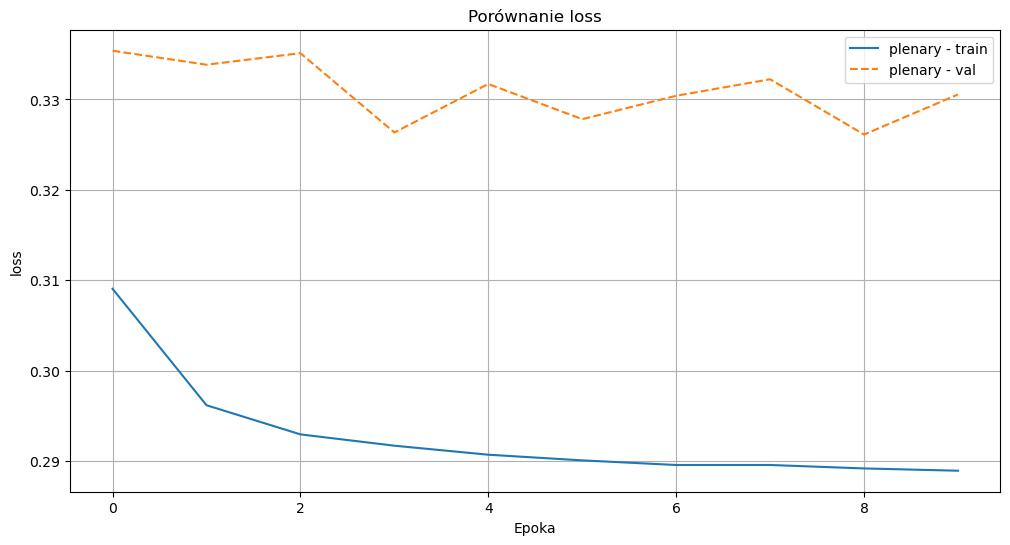

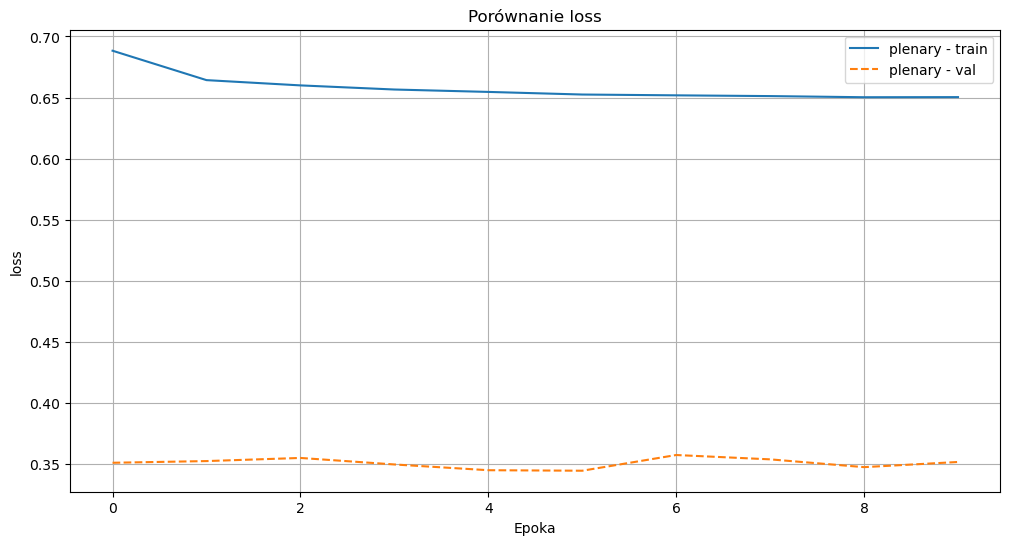

In [93]:
plot_metric(histories_flat_plenary, 'loss')
plot_metric(histories_flat_plenary_nw, 'loss')

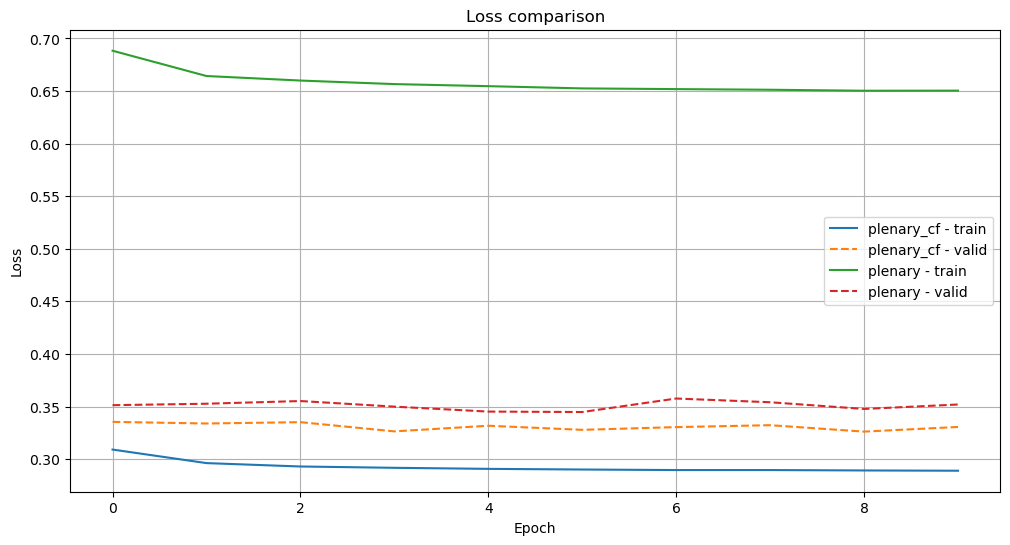

In [95]:

plt.figure(figsize=(12, 6))
    
 
plt.plot(histories_flat_plenary['plenary'].history['loss'], label=f'{model_name}_cf - train')
plt.plot(histories_flat_plenary['plenary'].history['val_loss'],linestyle='--', label=f'{model_name}_cf - valid')
plt.plot(histories_flat_plenary_nw['plenary'].history['loss'], label=f'{model_name} - train')
plt.plot(histories_flat_plenary_nw['plenary'].history['val_loss'],linestyle='--', label=f'{model_name} - valid')
 
    
plt.title(f'Loss comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [96]:
import seaborn as sns
for model_name, model in trained_models_flat_plenary.items():
    print(f'Evaluating {model_name}...')
    # Ocena modelu na zbiorze testowym
    #loss, accuracy, weighted_accuracy  = model.evaluate(X_test_scaled, Y_test )
    
    # Przewidywania na zbiorze testowym
    y_pred_probs = model.predict(X_test_scaled_flat)

    roc_auc = roc_auc_score(Y_test_flat, y_pred_probs, average='macro', multi_class='ovr')           

    print(f"Model {model_name} having AUC-ROC (macro average): {roc_auc:.4f}")

    # Zakładając, że masz dane testowe i model wytrenowany
    num_classes = num_classes  # liczba klas
    
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(Y_test_flat, axis=1)
    # Konwersja prawdziwych etykiet do formatu one-hot, jeśli jeszcze nie są
    y_true_onehot = Y_test_flat

    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)  

    # Inicjalizacja wykresu
    plt.figure(figsize=(10, 8))

    # Obliczenie krzywych ROC dla każdej klasy
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Klasa {i} (AUC = {roc_auc:.2f})")

    # Dodanie przekątnej dla klasyfikacji losowej
    plt.plot([0, 1], [0, 1], 'k--', label='Losowa klasyfikacja (AUC = 0.50)')

    # Dostosowanie wykresu
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Wykres ROC AUC dla każdej klasy")
    plt.legend(loc="lower right")
    plt.grid()

    # Wyświetlenie wykresu
    plt.show()

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=class_names, yticklabels=class_names)
    plt.title('Macierz pomyłek')
    plt.xlabel('Przewidywana etykieta')
    plt.ylabel('Prawdziwa etykieta')
    plt.show()

Evaluating plenary...
8938/8938 [==============================] - 24s 3ms/step


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 286000) + inhomogeneous part.

In [ ]:
import seaborn as sns
for model_name, model in trained_models_flat_plenary_nw.items():
    print(f'Evaluating {model_name}...')
    # Ocena modelu na zbiorze testowym
    #loss, accuracy, weighted_accuracy  = model.evaluate(X_test_scaled, Y_test )
    
    # Przewidywania na zbiorze testowym
    y_pred_probs = model.predict(X_test_scaled_flat)

    roc_auc = roc_auc_score(Y_test_flat, y_pred_probs, average='macro', multi_class='ovr')           

    print(f"Model {model_name} having AUC-ROC (macro average): {roc_auc:.4f}")

    # Zakładając, że masz dane testowe i model wytrenowany
    num_classes = num_classes  # liczba klas
    
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(Y_test_flat, axis=1)
    # Konwersja prawdziwych etykiet do formatu one-hot, jeśli jeszcze nie są
    y_true_onehot = Y_test_flat

    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)  

    # Inicjalizacja wykresu
    plt.figure(figsize=(10, 8))

    # Obliczenie krzywych ROC dla każdej klasy
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Klasa {i} (AUC = {roc_auc:.2f})")

    # Dodanie przekątnej dla klasyfikacji losowej
    plt.plot([0, 1], [0, 1], 'k--', label='Losowa klasyfikacja (AUC = 0.50)')

    # Dostosowanie wykresu
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Wykres ROC AUC dla każdej klasy")
    plt.legend(loc="lower right")
    plt.grid()

    # Wyświetlenie wykresu
    plt.show()

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=class_names, yticklabels=class_names)
    plt.title('Macierz pomyłek')
    plt.xlabel('Przewidywana etykieta')
    plt.ylabel('Prawdziwa etykieta')
    plt.show()

In [ ]:
# model_name='two_head'
# y_pred_states = two_head.predict(X_test_scaled)

# y_pred_states = np.argmax(y_pred_states[1][:], axis=1)

# cm_th_class = confusion_matrix(y_test_states_encoded, y_pred_states)
# cr_th_class = classification_report(y_test_states_encoded, y_pred_states)

# print(cm_th_class)
# print(cr_th_class)

## SHAP

In [ ]:
import shap
shap.initjs()

In [ ]:
model = trained_models_flat_plenary_nw['plenary']
background_size = 100  # Adjust based on your dataset size and computational resources
background_indices = np.random.choice(X_train_scaled_flat2.shape[0], background_size, replace=False)
background = X_train_scaled_flat2[background_indices]

In [120]:
def predict_symptom_output(x):
    # Ensure x is a numpy array
    x = np.array(x)
    preds = trained_models_flat_plenary_nw['plenary'].predict(x)
    return preds[0]

def predict_state_output(x):
    # Ensure x is a numpy array
    x = np.array(x)
    preds = trained_models_flat_plenary_nw['plenary'].predict(x)
    return preds[1]

In [127]:
# Example for a single-output model
explainer_state = shap.KernelExplainer(lambda x: predict_state_output(x), background) 


4/4 [==============================] - 0s 3ms/step


In [162]:
test_flat_length = len(X_test_scaled_flat)
test_flat_length

286000

In [207]:
end = len(X_test_scaled_flat)
shap_values = explainer_state.shap_values(X_test_scaled_flat[1 :end:1000, : ]) # 2,5h
#shap_values = explainer_state.shap_values(X_test_scaled_flat[1 :20, : ]) # 2,5h

  0%|          | 0/286 [00:00<?, ?it/s]

6938/6938 [==============================] - 20s 3ms/step


  0%|          | 1/286 [00:32<2:36:18, 32.91s/it]

6938/6938 [==============================] - 19s 3ms/step


  1%|          | 2/286 [01:04<2:32:37, 32.25s/it]

6938/6938 [==============================] - 19s 3ms/step


  1%|          | 3/286 [01:37<2:33:04, 32.45s/it]

6938/6938 [==============================] - 17s 2ms/step


  1%|▏         | 4/286 [02:06<2:26:16, 31.12s/it]

6938/6938 [==============================] - 17s 2ms/step


  2%|▏         | 5/286 [02:35<2:22:12, 30.37s/it]

6938/6938 [==============================] - 17s 2ms/step


  2%|▏         | 6/286 [03:04<2:19:37, 29.92s/it]

6938/6938 [==============================] - 17s 2ms/step


  2%|▏         | 7/286 [03:33<2:17:52, 29.65s/it]

6938/6938 [==============================] - 17s 2ms/step


  3%|▎         | 8/286 [04:02<2:16:28, 29.45s/it]

6938/6938 [==============================] - 17s 2ms/step


  3%|▎         | 9/286 [04:31<2:15:07, 29.27s/it]

6938/6938 [==============================] - 17s 2ms/step


  3%|▎         | 10/286 [05:00<2:14:26, 29.23s/it]

6938/6938 [==============================] - 17s 2ms/step


  4%|▍         | 11/286 [05:30<2:14:18, 29.30s/it]

6938/6938 [==============================] - 17s 2ms/step


  4%|▍         | 12/286 [05:59<2:13:34, 29.25s/it]

6938/6938 [==============================] - 17s 2ms/step


  5%|▍         | 13/286 [06:28<2:12:33, 29.13s/it]

6938/6938 [==============================] - 17s 2ms/step


  5%|▍         | 14/286 [06:57<2:12:04, 29.13s/it]

6938/6938 [==============================] - 17s 2ms/step


  5%|▌         | 15/286 [07:26<2:11:54, 29.21s/it]

6938/6938 [==============================] - 17s 2ms/step


  6%|▌         | 16/286 [07:55<2:10:55, 29.09s/it]

6938/6938 [==============================] - 17s 2ms/step


  6%|▌         | 17/286 [08:24<2:10:17, 29.06s/it]

6938/6938 [==============================] - 17s 2ms/step


  6%|▋         | 18/286 [08:53<2:09:22, 28.96s/it]

6938/6938 [==============================] - 17s 2ms/step


  7%|▋         | 19/286 [09:21<2:08:39, 28.91s/it]

6938/6938 [==============================] - 17s 2ms/step


  7%|▋         | 20/286 [09:50<2:08:05, 28.89s/it]

6938/6938 [==============================] - 17s 2ms/step


  7%|▋         | 21/286 [10:19<2:07:48, 28.94s/it]

6938/6938 [==============================] - 17s 2ms/step


  8%|▊         | 22/286 [10:49<2:07:57, 29.08s/it]

6938/6938 [==============================] - 17s 2ms/step


  8%|▊         | 23/286 [11:18<2:07:40, 29.13s/it]

6938/6938 [==============================] - 17s 2ms/step


  8%|▊         | 24/286 [11:47<2:06:58, 29.08s/it]

6938/6938 [==============================] - 17s 2ms/step


  9%|▊         | 25/286 [12:16<2:06:12, 29.02s/it]

6938/6938 [==============================] - 17s 2ms/step


  9%|▉         | 26/286 [12:45<2:05:55, 29.06s/it]

6938/6938 [==============================] - 17s 2ms/step


  9%|▉         | 27/286 [13:14<2:05:12, 29.01s/it]

6938/6938 [==============================] - 17s 2ms/step


 10%|▉         | 28/286 [13:43<2:04:28, 28.95s/it]

6938/6938 [==============================] - 17s 2ms/step


 10%|█         | 29/286 [14:12<2:04:02, 28.96s/it]

6938/6938 [==============================] - 17s 2ms/step


 10%|█         | 30/286 [14:40<2:03:16, 28.89s/it]

6938/6938 [==============================] - 17s 2ms/step


 11%|█         | 31/286 [15:09<2:02:37, 28.85s/it]

6938/6938 [==============================] - 17s 2ms/step


 11%|█         | 32/286 [15:39<2:02:43, 28.99s/it]

6938/6938 [==============================] - 17s 2ms/step


 12%|█▏        | 33/286 [16:08<2:02:36, 29.08s/it]

6938/6938 [==============================] - 17s 2ms/step


 12%|█▏        | 34/286 [16:37<2:01:52, 29.02s/it]

6938/6938 [==============================] - 17s 2ms/step


 12%|█▏        | 35/286 [17:06<2:01:36, 29.07s/it]

6938/6938 [==============================] - 17s 2ms/step


 13%|█▎        | 36/286 [17:35<2:01:18, 29.11s/it]

6938/6938 [==============================] - 17s 2ms/step


 13%|█▎        | 37/286 [18:04<2:01:10, 29.20s/it]

6938/6938 [==============================] - 17s 2ms/step


 13%|█▎        | 38/286 [18:34<2:00:36, 29.18s/it]

6938/6938 [==============================] - 17s 2ms/step


 14%|█▎        | 39/286 [19:02<1:59:45, 29.09s/it]

6938/6938 [==============================] - 17s 2ms/step


 14%|█▍        | 40/286 [19:31<1:58:46, 28.97s/it]

6938/6938 [==============================] - 17s 2ms/step


 14%|█▍        | 41/286 [20:00<1:58:25, 29.00s/it]

6938/6938 [==============================] - 17s 2ms/step


 15%|█▍        | 42/286 [20:29<1:58:11, 29.07s/it]

6938/6938 [==============================] - 17s 2ms/step


 15%|█▌        | 43/286 [20:58<1:57:18, 28.96s/it]

6938/6938 [==============================] - 17s 2ms/step


 15%|█▌        | 44/286 [21:27<1:56:38, 28.92s/it]

6938/6938 [==============================] - 17s 2ms/step


 16%|█▌        | 45/286 [21:56<1:56:01, 28.89s/it]

6938/6938 [==============================] - 17s 2ms/step


 16%|█▌        | 46/286 [22:25<1:55:19, 28.83s/it]

6938/6938 [==============================] - 17s 2ms/step


 16%|█▋        | 47/286 [22:54<1:55:08, 28.91s/it]

6938/6938 [==============================] - 17s 2ms/step


 17%|█▋        | 48/286 [23:23<1:54:52, 28.96s/it]

6938/6938 [==============================] - 17s 2ms/step


 17%|█▋        | 49/286 [23:52<1:54:47, 29.06s/it]

6938/6938 [==============================] - 17s 2ms/step


 17%|█▋        | 50/286 [24:21<1:54:05, 29.01s/it]

6938/6938 [==============================] - 17s 2ms/step


 18%|█▊        | 51/286 [24:50<1:53:26, 28.96s/it]

6938/6938 [==============================] - 17s 2ms/step


 18%|█▊        | 52/286 [25:19<1:53:00, 28.98s/it]

6938/6938 [==============================] - 17s 2ms/step


 19%|█▊        | 53/286 [25:48<1:52:55, 29.08s/it]

6938/6938 [==============================] - 17s 2ms/step


 19%|█▉        | 54/286 [26:17<1:52:07, 29.00s/it]

6938/6938 [==============================] - 17s 2ms/step


 19%|█▉        | 55/286 [26:46<1:51:20, 28.92s/it]

6938/6938 [==============================] - 17s 2ms/step


 20%|█▉        | 56/286 [27:14<1:50:31, 28.83s/it]

6938/6938 [==============================] - 17s 2ms/step


 20%|█▉        | 57/286 [27:43<1:49:53, 28.79s/it]

6938/6938 [==============================] - 17s 2ms/step


 20%|██        | 58/286 [28:12<1:49:32, 28.82s/it]

6938/6938 [==============================] - 17s 2ms/step


 21%|██        | 59/286 [28:41<1:49:10, 28.86s/it]

6938/6938 [==============================] - 17s 2ms/step


 21%|██        | 60/286 [29:10<1:48:45, 28.88s/it]

6938/6938 [==============================] - 17s 2ms/step


 21%|██▏       | 61/286 [29:39<1:48:17, 28.88s/it]

6938/6938 [==============================] - 17s 2ms/step


 22%|██▏       | 62/286 [30:07<1:47:48, 28.88s/it]

6938/6938 [==============================] - 17s 2ms/step


 22%|██▏       | 63/286 [30:37<1:47:37, 28.96s/it]

6938/6938 [==============================] - 17s 2ms/step


 22%|██▏       | 64/286 [31:05<1:47:05, 28.94s/it]

6938/6938 [==============================] - 17s 2ms/step


 23%|██▎       | 65/286 [31:34<1:46:28, 28.91s/it]

6938/6938 [==============================] - 17s 2ms/step


 23%|██▎       | 66/286 [32:03<1:45:53, 28.88s/it]

6938/6938 [==============================] - 17s 2ms/step


 23%|██▎       | 67/286 [32:32<1:45:20, 28.86s/it]

6938/6938 [==============================] - 17s 2ms/step


 24%|██▍       | 68/286 [33:01<1:44:55, 28.88s/it]

6938/6938 [==============================] - 17s 2ms/step


 24%|██▍       | 69/286 [33:30<1:44:24, 28.87s/it]

6938/6938 [==============================] - 17s 2ms/step


 24%|██▍       | 70/286 [33:59<1:44:08, 28.93s/it]

6938/6938 [==============================] - 17s 2ms/step


 25%|██▍       | 71/286 [34:28<1:43:41, 28.94s/it]

6938/6938 [==============================] - 17s 2ms/step


 25%|██▌       | 72/286 [34:57<1:43:23, 28.99s/it]

6938/6938 [==============================] - 17s 2ms/step


 26%|██▌       | 73/286 [35:26<1:43:07, 29.05s/it]

6938/6938 [==============================] - 17s 2ms/step


 26%|██▌       | 74/286 [35:55<1:42:26, 28.99s/it]

6938/6938 [==============================] - 17s 2ms/step


 26%|██▌       | 75/286 [36:24<1:42:12, 29.07s/it]

6938/6938 [==============================] - 17s 2ms/step


 27%|██▋       | 76/286 [36:53<1:41:47, 29.08s/it]

6938/6938 [==============================] - 17s 2ms/step


 27%|██▋       | 77/286 [37:22<1:41:16, 29.07s/it]

6938/6938 [==============================] - 17s 2ms/step


 27%|██▋       | 78/286 [37:51<1:40:46, 29.07s/it]

6938/6938 [==============================] - 17s 2ms/step


 28%|██▊       | 79/286 [38:20<1:40:00, 28.99s/it]

6938/6938 [==============================] - 17s 2ms/step


 28%|██▊       | 80/286 [38:49<1:39:12, 28.90s/it]

6938/6938 [==============================] - 17s 2ms/step


 28%|██▊       | 81/286 [39:18<1:38:39, 28.88s/it]

6938/6938 [==============================] - 17s 2ms/step


 29%|██▊       | 82/286 [39:46<1:38:01, 28.83s/it]

6938/6938 [==============================] - 17s 2ms/step


 29%|██▉       | 83/286 [40:15<1:37:40, 28.87s/it]

6938/6938 [==============================] - 17s 2ms/step


 29%|██▉       | 84/286 [40:45<1:37:33, 28.98s/it]

6938/6938 [==============================] - 17s 2ms/step


 30%|██▉       | 85/286 [41:13<1:36:52, 28.92s/it]

6938/6938 [==============================] - 17s 2ms/step


 30%|███       | 86/286 [41:42<1:36:17, 28.89s/it]

6938/6938 [==============================] - 17s 2ms/step


 30%|███       | 87/286 [42:11<1:35:55, 28.92s/it]

6938/6938 [==============================] - 17s 2ms/step


 31%|███       | 88/286 [42:40<1:35:27, 28.93s/it]

6938/6938 [==============================] - 17s 2ms/step


 31%|███       | 89/286 [43:09<1:34:57, 28.92s/it]

6938/6938 [==============================] - 17s 2ms/step


 31%|███▏      | 90/286 [43:38<1:34:24, 28.90s/it]

6938/6938 [==============================] - 17s 2ms/step


 32%|███▏      | 91/286 [44:07<1:34:06, 28.96s/it]

6938/6938 [==============================] - 17s 2ms/step


 32%|███▏      | 92/286 [44:36<1:33:36, 28.95s/it]

6938/6938 [==============================] - 17s 2ms/step


 33%|███▎      | 93/286 [45:05<1:33:24, 29.04s/it]

6938/6938 [==============================] - 17s 2ms/step


 33%|███▎      | 94/286 [45:34<1:32:57, 29.05s/it]

6938/6938 [==============================] - 17s 2ms/step


 33%|███▎      | 95/286 [46:04<1:32:46, 29.14s/it]

6938/6938 [==============================] - 17s 2ms/step


 34%|███▎      | 96/286 [46:33<1:32:13, 29.12s/it]

6938/6938 [==============================] - 17s 2ms/step


 34%|███▍      | 97/286 [47:02<1:31:29, 29.05s/it]

6938/6938 [==============================] - 17s 2ms/step


 34%|███▍      | 98/286 [47:30<1:30:55, 29.02s/it]

6938/6938 [==============================] - 17s 2ms/step


 35%|███▍      | 99/286 [47:59<1:30:12, 28.94s/it]

6938/6938 [==============================] - 17s 2ms/step


 35%|███▍      | 100/286 [48:28<1:29:45, 28.96s/it]

6938/6938 [==============================] - 17s 2ms/step


 35%|███▌      | 101/286 [48:57<1:29:31, 29.03s/it]

6938/6938 [==============================] - 17s 2ms/step


 36%|███▌      | 102/286 [49:26<1:28:45, 28.94s/it]

6938/6938 [==============================] - 17s 2ms/step


 36%|███▌      | 103/286 [49:56<1:28:50, 29.13s/it]

6938/6938 [==============================] - 17s 2ms/step


 36%|███▋      | 104/286 [50:25<1:28:16, 29.10s/it]

6938/6938 [==============================] - 17s 2ms/step


 37%|███▋      | 105/286 [50:54<1:27:37, 29.05s/it]

6938/6938 [==============================] - 17s 2ms/step


 37%|███▋      | 106/286 [51:23<1:26:58, 28.99s/it]

6938/6938 [==============================] - 17s 2ms/step


 37%|███▋      | 107/286 [51:52<1:26:28, 28.99s/it]

6938/6938 [==============================] - 17s 2ms/step


 38%|███▊      | 108/286 [52:21<1:26:35, 29.19s/it]

6938/6938 [==============================] - 17s 2ms/step


 38%|███▊      | 109/286 [52:50<1:25:50, 29.10s/it]

6938/6938 [==============================] - 17s 2ms/step


 38%|███▊      | 110/286 [53:19<1:25:07, 29.02s/it]

6938/6938 [==============================] - 17s 2ms/step


 39%|███▉      | 111/286 [53:48<1:24:56, 29.12s/it]

6938/6938 [==============================] - 17s 2ms/step


 39%|███▉      | 112/286 [54:17<1:24:08, 29.01s/it]

6938/6938 [==============================] - 17s 2ms/step


 40%|███▉      | 113/286 [54:46<1:23:36, 29.00s/it]

6938/6938 [==============================] - 17s 2ms/step


 40%|███▉      | 114/286 [55:15<1:23:10, 29.01s/it]

6938/6938 [==============================] - 17s 2ms/step


 40%|████      | 115/286 [55:44<1:22:37, 28.99s/it]

6938/6938 [==============================] - 17s 2ms/step


 41%|████      | 116/286 [56:13<1:21:52, 28.90s/it]

6938/6938 [==============================] - 17s 2ms/step


 41%|████      | 117/286 [56:42<1:21:44, 29.02s/it]

6938/6938 [==============================] - 17s 2ms/step


 41%|████▏     | 118/286 [57:11<1:21:03, 28.95s/it]

6938/6938 [==============================] - 17s 2ms/step


 42%|████▏     | 119/286 [57:40<1:20:37, 28.97s/it]

6938/6938 [==============================] - 17s 2ms/step


 42%|████▏     | 120/286 [58:09<1:20:11, 28.98s/it]

6938/6938 [==============================] - 17s 2ms/step


 42%|████▏     | 121/286 [58:38<1:19:41, 28.98s/it]

6938/6938 [==============================] - 17s 2ms/step


 43%|████▎     | 122/286 [59:07<1:19:15, 29.00s/it]

6938/6938 [==============================] - 17s 2ms/step


 43%|████▎     | 123/286 [59:36<1:18:56, 29.06s/it]

6938/6938 [==============================] - 17s 2ms/step


 43%|████▎     | 124/286 [1:00:05<1:18:31, 29.08s/it]

6938/6938 [==============================] - 17s 2ms/step


 44%|████▎     | 125/286 [1:00:34<1:18:04, 29.10s/it]

6938/6938 [==============================] - 17s 2ms/step


 44%|████▍     | 126/286 [1:01:03<1:17:33, 29.09s/it]

6938/6938 [==============================] - 17s 2ms/step


 44%|████▍     | 127/286 [1:01:32<1:17:00, 29.06s/it]

6938/6938 [==============================] - 17s 2ms/step


 45%|████▍     | 128/286 [1:02:01<1:16:18, 28.98s/it]

6938/6938 [==============================] - 17s 2ms/step


 45%|████▌     | 129/286 [1:02:30<1:15:41, 28.93s/it]

6938/6938 [==============================] - 17s 2ms/step


 45%|████▌     | 130/286 [1:02:59<1:15:00, 28.85s/it]

6938/6938 [==============================] - 17s 2ms/step


 46%|████▌     | 131/286 [1:03:28<1:14:43, 28.92s/it]

6938/6938 [==============================] - 17s 2ms/step


 46%|████▌     | 132/286 [1:03:56<1:14:07, 28.88s/it]

6938/6938 [==============================] - 17s 2ms/step


 47%|████▋     | 133/286 [1:04:25<1:13:30, 28.83s/it]

6938/6938 [==============================] - 17s 2ms/step


 47%|████▋     | 134/286 [1:04:54<1:13:12, 28.90s/it]

6938/6938 [==============================] - 17s 2ms/step


 47%|████▋     | 135/286 [1:05:23<1:12:56, 28.98s/it]

6938/6938 [==============================] - 17s 2ms/step


 48%|████▊     | 136/286 [1:05:52<1:12:16, 28.91s/it]

6938/6938 [==============================] - 17s 2ms/step


 48%|████▊     | 137/286 [1:06:21<1:11:42, 28.88s/it]

6938/6938 [==============================] - 17s 2ms/step


 48%|████▊     | 138/286 [1:06:50<1:11:26, 28.97s/it]

6938/6938 [==============================] - 17s 2ms/step


 49%|████▊     | 139/286 [1:07:19<1:10:50, 28.91s/it]

6938/6938 [==============================] - 17s 2ms/step


 49%|████▉     | 140/286 [1:07:48<1:10:14, 28.87s/it]

6938/6938 [==============================] - 17s 2ms/step


 49%|████▉     | 141/286 [1:08:17<1:09:56, 28.94s/it]

6938/6938 [==============================] - 17s 2ms/step


 50%|████▉     | 142/286 [1:08:46<1:09:32, 28.97s/it]

6938/6938 [==============================] - 17s 2ms/step


 50%|█████     | 143/286 [1:09:15<1:08:57, 28.93s/it]

6938/6938 [==============================] - 17s 2ms/step


 50%|█████     | 144/286 [1:09:44<1:08:38, 29.00s/it]

6938/6938 [==============================] - 17s 2ms/step


 51%|█████     | 145/286 [1:10:13<1:08:02, 28.96s/it]

6938/6938 [==============================] - 17s 2ms/step


 51%|█████     | 146/286 [1:10:42<1:07:34, 28.96s/it]

6938/6938 [==============================] - 17s 2ms/step


 51%|█████▏    | 147/286 [1:11:11<1:06:59, 28.92s/it]

6938/6938 [==============================] - 17s 2ms/step


 52%|█████▏    | 148/286 [1:11:40<1:06:41, 29.00s/it]

6938/6938 [==============================] - 17s 2ms/step


 52%|█████▏    | 149/286 [1:12:09<1:06:23, 29.08s/it]

6938/6938 [==============================] - 17s 2ms/step


 52%|█████▏    | 150/286 [1:12:38<1:05:53, 29.07s/it]

6938/6938 [==============================] - 17s 2ms/step


 53%|█████▎    | 151/286 [1:13:07<1:05:33, 29.14s/it]

6938/6938 [==============================] - 17s 2ms/step


 53%|█████▎    | 152/286 [1:13:36<1:05:03, 29.13s/it]

6938/6938 [==============================] - 17s 2ms/step


 53%|█████▎    | 153/286 [1:14:05<1:04:30, 29.10s/it]

6938/6938 [==============================] - 17s 2ms/step


 54%|█████▍    | 154/286 [1:14:35<1:04:03, 29.12s/it]

6938/6938 [==============================] - 17s 2ms/step


 54%|█████▍    | 155/286 [1:15:04<1:03:35, 29.12s/it]

6938/6938 [==============================] - 17s 2ms/step


 55%|█████▍    | 156/286 [1:15:33<1:02:54, 29.03s/it]

6938/6938 [==============================] - 17s 2ms/step


 55%|█████▍    | 157/286 [1:16:02<1:02:29, 29.07s/it]

6938/6938 [==============================] - 17s 2ms/step


 55%|█████▌    | 158/286 [1:16:31<1:02:06, 29.11s/it]

6938/6938 [==============================] - 17s 2ms/step


 56%|█████▌    | 159/286 [1:17:00<1:01:34, 29.09s/it]

6938/6938 [==============================] - 17s 2ms/step


 56%|█████▌    | 160/286 [1:17:29<1:00:54, 29.00s/it]

6938/6938 [==============================] - 17s 2ms/step


 56%|█████▋    | 161/286 [1:17:58<1:00:19, 28.96s/it]

6938/6938 [==============================] - 17s 2ms/step


 57%|█████▋    | 162/286 [1:18:27<59:53, 28.98s/it]  

6938/6938 [==============================] - 17s 2ms/step


 57%|█████▋    | 163/286 [1:18:56<59:27, 29.00s/it]

6938/6938 [==============================] - 17s 2ms/step


 57%|█████▋    | 164/286 [1:19:25<59:04, 29.05s/it]

6938/6938 [==============================] - 17s 2ms/step


 58%|█████▊    | 165/286 [1:19:54<58:41, 29.10s/it]

6938/6938 [==============================] - 17s 2ms/step


 58%|█████▊    | 166/286 [1:20:23<58:06, 29.05s/it]

6938/6938 [==============================] - 17s 2ms/step


 58%|█████▊    | 167/286 [1:20:52<57:41, 29.09s/it]

6938/6938 [==============================] - 17s 2ms/step


 59%|█████▊    | 168/286 [1:21:21<57:16, 29.12s/it]

6938/6938 [==============================] - 17s 2ms/step


 59%|█████▉    | 169/286 [1:21:51<56:56, 29.20s/it]

6938/6938 [==============================] - 17s 2ms/step


 59%|█████▉    | 170/286 [1:22:20<56:27, 29.20s/it]

6938/6938 [==============================] - 17s 2ms/step


 60%|█████▉    | 171/286 [1:22:49<55:55, 29.17s/it]

6938/6938 [==============================] - 17s 2ms/step


 60%|██████    | 172/286 [1:23:18<55:28, 29.20s/it]

6938/6938 [==============================] - 17s 2ms/step


 60%|██████    | 173/286 [1:23:47<54:47, 29.09s/it]

6938/6938 [==============================] - 17s 2ms/step


 61%|██████    | 174/286 [1:24:16<54:15, 29.06s/it]

6938/6938 [==============================] - 17s 2ms/step


 61%|██████    | 175/286 [1:24:45<53:39, 29.01s/it]

6938/6938 [==============================] - 17s 2ms/step


 62%|██████▏   | 176/286 [1:25:14<53:14, 29.04s/it]

6938/6938 [==============================] - 17s 2ms/step


 62%|██████▏   | 177/286 [1:25:43<52:38, 28.98s/it]

6938/6938 [==============================] - 17s 2ms/step


 62%|██████▏   | 178/286 [1:26:12<52:06, 28.95s/it]

6938/6938 [==============================] - 17s 2ms/step


 63%|██████▎   | 179/286 [1:26:41<51:32, 28.91s/it]

6938/6938 [==============================] - 17s 2ms/step


 63%|██████▎   | 180/286 [1:27:10<51:03, 28.90s/it]

6938/6938 [==============================] - 17s 2ms/step


 63%|██████▎   | 181/286 [1:27:39<50:39, 28.95s/it]

6938/6938 [==============================] - 17s 2ms/step


 64%|██████▎   | 182/286 [1:28:08<50:21, 29.05s/it]

6938/6938 [==============================] - 17s 2ms/step


 64%|██████▍   | 183/286 [1:28:37<49:47, 29.01s/it]

6938/6938 [==============================] - 17s 2ms/step


 64%|██████▍   | 184/286 [1:29:06<49:12, 28.94s/it]

6938/6938 [==============================] - 17s 2ms/step


 65%|██████▍   | 185/286 [1:29:35<48:43, 28.95s/it]

6938/6938 [==============================] - 17s 2ms/step


 65%|██████▌   | 186/286 [1:30:04<48:23, 29.03s/it]

6938/6938 [==============================] - 17s 2ms/step


 65%|██████▌   | 187/286 [1:30:33<47:50, 29.00s/it]

6938/6938 [==============================] - 17s 2ms/step


 66%|██████▌   | 188/286 [1:31:02<47:29, 29.08s/it]

6938/6938 [==============================] - 17s 2ms/step


 66%|██████▌   | 189/286 [1:31:31<46:57, 29.05s/it]

6938/6938 [==============================] - 17s 2ms/step


 66%|██████▋   | 190/286 [1:32:00<46:27, 29.03s/it]

6938/6938 [==============================] - 17s 2ms/step


 67%|██████▋   | 191/286 [1:32:29<45:59, 29.05s/it]

6938/6938 [==============================] - 17s 2ms/step


 67%|██████▋   | 192/286 [1:32:58<45:28, 29.02s/it]

6938/6938 [==============================] - 17s 2ms/step


 67%|██████▋   | 193/286 [1:33:27<45:05, 29.09s/it]

6938/6938 [==============================] - 17s 2ms/step


 68%|██████▊   | 194/286 [1:33:56<44:36, 29.09s/it]

6938/6938 [==============================] - 17s 2ms/step


 68%|██████▊   | 195/286 [1:34:26<44:11, 29.14s/it]

6938/6938 [==============================] - 17s 2ms/step


 69%|██████▊   | 196/286 [1:34:55<43:41, 29.13s/it]

6938/6938 [==============================] - 17s 2ms/step


 69%|██████▉   | 197/286 [1:35:24<43:08, 29.08s/it]

6938/6938 [==============================] - 17s 2ms/step


 69%|██████▉   | 198/286 [1:35:53<42:31, 28.99s/it]

6938/6938 [==============================] - 17s 2ms/step


 70%|██████▉   | 199/286 [1:36:21<41:56, 28.93s/it]

6938/6938 [==============================] - 17s 2ms/step


 70%|██████▉   | 200/286 [1:36:51<41:38, 29.05s/it]

6938/6938 [==============================] - 17s 2ms/step


 70%|███████   | 201/286 [1:37:19<41:02, 28.97s/it]

6938/6938 [==============================] - 17s 2ms/step


 71%|███████   | 202/286 [1:37:49<40:48, 29.15s/it]

6938/6938 [==============================] - 17s 2ms/step


 71%|███████   | 203/286 [1:38:18<40:20, 29.16s/it]

6938/6938 [==============================] - 17s 2ms/step


 71%|███████▏  | 204/286 [1:38:47<39:51, 29.16s/it]

6938/6938 [==============================] - 17s 2ms/step


 72%|███████▏  | 205/286 [1:39:16<39:14, 29.07s/it]

6938/6938 [==============================] - 17s 2ms/step


 72%|███████▏  | 206/286 [1:39:45<38:51, 29.14s/it]

6938/6938 [==============================] - 17s 2ms/step


 72%|███████▏  | 207/286 [1:40:14<38:17, 29.08s/it]

6938/6938 [==============================] - 17s 2ms/step


 73%|███████▎  | 208/286 [1:40:43<37:43, 29.02s/it]

6938/6938 [==============================] - 17s 2ms/step


 73%|███████▎  | 209/286 [1:41:12<37:15, 29.03s/it]

6938/6938 [==============================] - 17s 2ms/step


 73%|███████▎  | 210/286 [1:41:41<36:46, 29.03s/it]

6938/6938 [==============================] - 17s 2ms/step


 74%|███████▍  | 211/286 [1:42:10<36:15, 29.01s/it]

6938/6938 [==============================] - 17s 2ms/step


 74%|███████▍  | 212/286 [1:42:40<35:51, 29.08s/it]

6938/6938 [==============================] - 17s 2ms/step


 74%|███████▍  | 213/286 [1:43:09<35:25, 29.12s/it]

6938/6938 [==============================] - 17s 2ms/step


 75%|███████▍  | 214/286 [1:43:38<34:52, 29.07s/it]

6938/6938 [==============================] - 17s 2ms/step


 75%|███████▌  | 215/286 [1:44:07<34:22, 29.05s/it]

6938/6938 [==============================] - 17s 2ms/step


 76%|███████▌  | 216/286 [1:44:36<33:50, 29.00s/it]

6938/6938 [==============================] - 17s 2ms/step


 76%|███████▌  | 217/286 [1:45:05<33:22, 29.03s/it]

6938/6938 [==============================] - 17s 2ms/step


 76%|███████▌  | 218/286 [1:45:34<32:53, 29.01s/it]

6938/6938 [==============================] - 17s 2ms/step


 77%|███████▋  | 219/286 [1:46:03<32:19, 28.95s/it]

6938/6938 [==============================] - 17s 2ms/step


 77%|███████▋  | 220/286 [1:46:31<31:49, 28.93s/it]

6938/6938 [==============================] - 17s 2ms/step


 77%|███████▋  | 221/286 [1:47:00<31:18, 28.90s/it]

6938/6938 [==============================] - 17s 2ms/step


 78%|███████▊  | 222/286 [1:47:29<30:49, 28.91s/it]

6938/6938 [==============================] - 17s 2ms/step


 78%|███████▊  | 223/286 [1:47:58<30:22, 28.93s/it]

6938/6938 [==============================] - 17s 2ms/step


 78%|███████▊  | 224/286 [1:48:27<29:53, 28.92s/it]

6938/6938 [==============================] - 17s 2ms/step


 79%|███████▊  | 225/286 [1:48:56<29:22, 28.90s/it]

6938/6938 [==============================] - 17s 2ms/step


 79%|███████▉  | 226/286 [1:49:25<28:59, 28.99s/it]

6938/6938 [==============================] - 17s 2ms/step


 79%|███████▉  | 227/286 [1:49:54<28:36, 29.10s/it]

6938/6938 [==============================] - 17s 2ms/step


 80%|███████▉  | 228/286 [1:50:23<28:03, 29.03s/it]

6938/6938 [==============================] - 17s 2ms/step


 80%|████████  | 229/286 [1:50:52<27:34, 29.02s/it]

6938/6938 [==============================] - 17s 2ms/step


 80%|████████  | 230/286 [1:51:21<27:02, 28.96s/it]

6938/6938 [==============================] - 17s 2ms/step


 81%|████████  | 231/286 [1:51:50<26:32, 28.95s/it]

6938/6938 [==============================] - 17s 2ms/step


 81%|████████  | 232/286 [1:52:19<26:00, 28.91s/it]

6938/6938 [==============================] - 17s 2ms/step


 81%|████████▏ | 233/286 [1:52:48<25:31, 28.90s/it]

6938/6938 [==============================] - 17s 2ms/step


 82%|████████▏ | 234/286 [1:53:17<25:02, 28.89s/it]

6938/6938 [==============================] - 17s 2ms/step


 82%|████████▏ | 235/286 [1:53:46<24:33, 28.89s/it]

6938/6938 [==============================] - 17s 2ms/step


 83%|████████▎ | 236/286 [1:54:14<24:04, 28.90s/it]

6938/6938 [==============================] - 17s 2ms/step


 83%|████████▎ | 237/286 [1:54:44<23:39, 28.97s/it]

6938/6938 [==============================] - 17s 2ms/step


 83%|████████▎ | 238/286 [1:55:13<23:12, 29.01s/it]

6938/6938 [==============================] - 17s 2ms/step


 84%|████████▎ | 239/286 [1:55:42<22:42, 28.98s/it]

6938/6938 [==============================] - 17s 2ms/step


 84%|████████▍ | 240/286 [1:56:10<22:08, 28.89s/it]

6938/6938 [==============================] - 17s 2ms/step


 84%|████████▍ | 241/286 [1:56:39<21:40, 28.90s/it]

6938/6938 [==============================] - 17s 2ms/step


 85%|████████▍ | 242/286 [1:57:08<21:11, 28.90s/it]

6938/6938 [==============================] - 17s 2ms/step


 85%|████████▍ | 243/286 [1:57:37<20:41, 28.88s/it]

6938/6938 [==============================] - 17s 2ms/step


 85%|████████▌ | 244/286 [1:58:06<20:18, 29.01s/it]

6938/6938 [==============================] - 17s 2ms/step


 86%|████████▌ | 245/286 [1:58:35<19:49, 29.01s/it]

6938/6938 [==============================] - 17s 2ms/step


 86%|████████▌ | 246/286 [1:59:04<19:19, 28.99s/it]

6938/6938 [==============================] - 17s 2ms/step


 86%|████████▋ | 247/286 [1:59:33<18:50, 28.98s/it]

6938/6938 [==============================] - 17s 2ms/step


 87%|████████▋ | 248/286 [2:00:03<18:26, 29.11s/it]

6938/6938 [==============================] - 17s 2ms/step


 87%|████████▋ | 249/286 [2:00:31<17:53, 29.02s/it]

6938/6938 [==============================] - 17s 2ms/step


 87%|████████▋ | 250/286 [2:01:01<17:26, 29.08s/it]

6938/6938 [==============================] - 17s 2ms/step


 88%|████████▊ | 251/286 [2:01:30<16:57, 29.08s/it]

6938/6938 [==============================] - 17s 2ms/step


 88%|████████▊ | 252/286 [2:01:59<16:26, 29.02s/it]

6938/6938 [==============================] - 17s 2ms/step


 88%|████████▊ | 253/286 [2:02:27<15:55, 28.97s/it]

6938/6938 [==============================] - 17s 2ms/step


 89%|████████▉ | 254/286 [2:02:56<15:26, 28.94s/it]

6938/6938 [==============================] - 17s 2ms/step


 89%|████████▉ | 255/286 [2:03:25<14:58, 28.97s/it]

6938/6938 [==============================] - 17s 2ms/step


 90%|████████▉ | 256/286 [2:03:54<14:30, 29.00s/it]

6938/6938 [==============================] - 17s 2ms/step


 90%|████████▉ | 257/286 [2:04:24<14:02, 29.04s/it]

6938/6938 [==============================] - 17s 2ms/step


 90%|█████████ | 258/286 [2:04:53<13:33, 29.06s/it]

6938/6938 [==============================] - 17s 2ms/step


 91%|█████████ | 259/286 [2:05:22<13:04, 29.05s/it]

6938/6938 [==============================] - 16s 2ms/step


 91%|█████████ | 260/286 [2:05:50<12:29, 28.81s/it]

6938/6938 [==============================] - 17s 2ms/step


 91%|█████████▏| 261/286 [2:06:19<12:01, 28.87s/it]

6938/6938 [==============================] - 17s 2ms/step


 92%|█████████▏| 262/286 [2:06:48<11:31, 28.80s/it]

6938/6938 [==============================] - 17s 2ms/step


 92%|█████████▏| 263/286 [2:07:17<11:03, 28.86s/it]

6938/6938 [==============================] - 17s 2ms/step


 92%|█████████▏| 264/286 [2:07:45<10:33, 28.78s/it]

6938/6938 [==============================] - 17s 2ms/step


 93%|█████████▎| 265/286 [2:08:14<10:04, 28.77s/it]

6938/6938 [==============================] - 17s 2ms/step


 93%|█████████▎| 266/286 [2:08:43<09:36, 28.82s/it]

6938/6938 [==============================] - 17s 2ms/step


 93%|█████████▎| 267/286 [2:09:12<09:08, 28.87s/it]

6938/6938 [==============================] - 17s 2ms/step


 94%|█████████▎| 268/286 [2:09:41<08:39, 28.86s/it]

6938/6938 [==============================] - 17s 2ms/step


 94%|█████████▍| 269/286 [2:10:09<08:10, 28.84s/it]

6938/6938 [==============================] - 17s 2ms/step


 94%|█████████▍| 270/286 [2:10:38<07:40, 28.76s/it]

6938/6938 [==============================] - 17s 2ms/step


 95%|█████████▍| 271/286 [2:11:07<07:11, 28.77s/it]

6938/6938 [==============================] - 17s 2ms/step


 95%|█████████▌| 272/286 [2:11:36<06:42, 28.74s/it]

6938/6938 [==============================] - 17s 2ms/step


 95%|█████████▌| 273/286 [2:12:04<06:13, 28.71s/it]

6938/6938 [==============================] - 17s 2ms/step


 96%|█████████▌| 274/286 [2:12:33<05:44, 28.74s/it]

6938/6938 [==============================] - 17s 2ms/step


 96%|█████████▌| 275/286 [2:13:02<05:16, 28.78s/it]

6938/6938 [==============================] - 17s 2ms/step


 97%|█████████▋| 276/286 [2:13:31<04:48, 28.81s/it]

6938/6938 [==============================] - 17s 2ms/step


 97%|█████████▋| 277/286 [2:14:00<04:19, 28.88s/it]

6938/6938 [==============================] - 16s 2ms/step


 97%|█████████▋| 278/286 [2:14:28<03:49, 28.74s/it]

6938/6938 [==============================] - 17s 2ms/step


 98%|█████████▊| 279/286 [2:14:57<03:21, 28.78s/it]

6938/6938 [==============================] - 17s 2ms/step


 98%|█████████▊| 280/286 [2:15:26<02:53, 28.84s/it]

6938/6938 [==============================] - 17s 2ms/step


 98%|█████████▊| 281/286 [2:15:55<02:24, 28.85s/it]

6938/6938 [==============================] - 17s 2ms/step


 99%|█████████▊| 282/286 [2:16:24<01:55, 28.82s/it]

6938/6938 [==============================] - 17s 2ms/step


 99%|█████████▉| 283/286 [2:16:52<01:26, 28.80s/it]

6938/6938 [==============================] - 17s 2ms/step


 99%|█████████▉| 284/286 [2:17:21<00:57, 28.72s/it]

6938/6938 [==============================] - 17s 2ms/step


100%|█████████▉| 285/286 [2:17:50<00:28, 28.81s/it]

6938/6938 [==============================] - 17s 2ms/step


100%|██████████| 286/286 [2:18:19<00:00, 29.02s/it]


In [208]:
shap_values_per_class = [shap_values[:, :, class_idx] for class_idx in range(4)]

In [223]:
len(shap_values_per_class[0])

286

In [240]:
shap_values

array([[[ 0.00865351, -0.1046643 , -0.13502904,  0.23139837],
        [ 0.03725534, -0.20116481,  0.15714453,  0.00427473],
        [-0.01557471, -0.04598857,  0.06395382,  0.        ],
        ...,
        [ 0.00643398,  0.        , -0.01302624,  0.        ],
        [ 0.00742166,  0.        ,  0.        ,  0.        ],
        [-0.09219706,  0.1635652 ,  0.03130343, -0.10144667]],

       [[ 0.01987691, -0.13110493, -0.13337071,  0.24487882],
        [ 0.03332422, -0.20061274,  0.15452469,  0.01159383],
        [-0.02138449, -0.05194337,  0.07994824, -0.00737253],
        ...,
        [-0.00553123,  0.01080035, -0.01089552,  0.00518848],
        [ 0.        ,  0.        , -0.01080613,  0.01223822],
        [-0.09358484,  0.16243399,  0.01870876, -0.08906033]],

       [[ 0.00603393, -0.12122233, -0.12241368,  0.23774812],
        [ 0.03755854, -0.21654681,  0.16356397,  0.0166313 ],
        [-0.00901922, -0.05622491,  0.07421218, -0.00747039],
        ...,
        [ 0.        , -0.00

## global explenation for each state

In [ ]:
#os.makedirs('shap_global_explanations', exist_ok=True)
class_names = ['euthymia','depression','mania','mixed']

for class_idx in range(4):
    class_shap_values = shap_values_per_class[class_idx]
    
    shap.summary_plot(
        class_shap_values,
        X_test_scaled_flat[1 :end:1000, : ],
        feature_names=feature_columns,
        max_display=10 ,
        #plot_type = 'bar',
        show=False
    )
    
    plt.title(f'SHAP Summary Plot for {class_names[class_idx]}')
    
    plt.savefig(f'shap_global_explanations/shap_summary_{class_names[class_idx]}.png', bbox_inches='tight')
    plt.close()

In [264]:
shap.summary_plot(
        shap_values_per_class ,
        X_test_scaled_flat[1 :end:1000, : ],
        feature_names=feature_columns,
        max_display=15 ,
        class_names =  class_names,
        show=False
    )
plt.title(f'SHAP Summary Plot for All BD states')
plt.savefig(f'shap_global_explanations/shap_summary_all_class.png', bbox_inches='tight')
plt.close()

In [237]:
class_shap_values[0]

array([ 0.23139837,  0.00427473,  0.        ,  0.        ,  0.09103218,
       -0.00521104,  0.        ,  0.0375552 ,  0.02933228, -0.10075634,
       -0.02782884,  0.        , -0.14298828, -0.01476446, -0.00588598,
        0.0295512 ,  0.00776235,  0.0105886 , -0.00653964,  0.00248193,
       -0.04159001, -0.01492997,  0.        ,  0.01390044,  0.        ,
        0.00568193,  0.00666486,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00815959, -0.00406929, -0.01013273,
        0.        ,  0.        , -0.00664461,  0.        ,  0.        ,
        0.00532311,  0.        ,  0.        , -0.00544296,  0.        ,
        0.00630587,  0.00728697,  0.        ,  0.01164804,  0.0058171 ,
       -0.00702618,  0.        ,  0.02904149, -0.04497386, -0.00602751,
       -0.01361596, -0.02049766,  0.00491807,  0.00620342, -0.02285906,
        0.03137906,  0.03411654,  0.02315412,  0.        ,  0.        ,
       -0.00595381,  0.02290133, -0.02100007, -0.01921088, -0.01

In [229]:
selected_samples = [0, 5, 10, 15, 18]  # Example indices within 0-18

# Generate Local SHAP Force Plots
for sample_idx in selected_samples:
    for class_idx in range(4):
        sample_shap_values = shap_values[sample_idx, :, class_idx]
        single_sample = X_test_scaled_flat[sample_idx].reshape(1, -1)
        
        shap.force_plot(
            explainer_state.expected_value[class_idx],
            sample_shap_values,
            single_sample,
            feature_names=feature_columns,
            matplotlib=True,
            show=False
        )
        
        plt.title(f'SHAP Force Plot for Sample {sample_idx} - {class_names[class_idx]}')
        plt.savefig(f'shap_local_explanations/shap_force_sample{sample_idx}_{class_names[class_idx]}.png', bbox_inches='tight')
        plt.close()

In [ ]:
# for class_id in range(len(shap_values)):
#   #I'm iterating on the number of features I want to plot
#   for max_features in [20, 40, 86]: 
#     shap.summary_plot(shap_values[class_id], X_test_scaled[1:end:1000,:], feature_names = feature_names, max_display=max_features,show=False)
#     plt.gcf()
#     figname=graphsStreamPath+model_name+'_global_class'+str(class_id)+'_features'+ str(max_features)+'.png'
#     plt.savefig(figname,dpi=150, bbox_inches='tight')
#     plt.clf()

### SHAP with symptoms

In [224]:
# Example for a single-output model
explainer_symptom = shap.KernelExplainer(lambda x: predict_symptom_output(x), background) 

4/4 [==============================] - 0s 3ms/step


In [225]:

shap_values_symptom = explainer_symptom.shap_values(X_test_scaled_flat[1 :end:1000, : ]) # 2,5h
#shap_values_symptom = explainer_symptom.shap_values(X_test_scaled_flat[1 :20, : ]) # 2,5h

  0%|          | 0/286 [00:00<?, ?it/s]

6938/6938 [==============================] - 20s 3ms/step


  0%|          | 1/286 [00:34<2:41:33, 34.01s/it]

6938/6938 [==============================] - 18s 3ms/step


  1%|          | 2/286 [01:04<2:30:38, 31.83s/it]

6938/6938 [==============================] - 17s 2ms/step


  1%|          | 3/286 [01:33<2:24:53, 30.72s/it]

6938/6938 [==============================] - 17s 2ms/step


  1%|▏         | 4/286 [02:02<2:21:40, 30.14s/it]

6938/6938 [==============================] - 17s 2ms/step


  2%|▏         | 5/286 [02:32<2:20:03, 29.91s/it]

6938/6938 [==============================] - 17s 2ms/step


  2%|▏         | 6/286 [03:01<2:18:50, 29.75s/it]

6938/6938 [==============================] - 17s 2ms/step


  2%|▏         | 7/286 [03:31<2:17:24, 29.55s/it]

6938/6938 [==============================] - 17s 2ms/step


  3%|▎         | 8/286 [04:00<2:16:17, 29.42s/it]

6938/6938 [==============================] - 17s 2ms/step


  3%|▎         | 9/286 [04:29<2:15:40, 29.39s/it]

6938/6938 [==============================] - 17s 2ms/step


  3%|▎         | 10/286 [04:58<2:14:50, 29.31s/it]

6938/6938 [==============================] - 17s 2ms/step


  4%|▍         | 11/286 [05:27<2:14:23, 29.32s/it]

6938/6938 [==============================] - 17s 2ms/step


  4%|▍         | 12/286 [05:57<2:14:03, 29.36s/it]

6938/6938 [==============================] - 17s 2ms/step


  5%|▍         | 13/286 [06:26<2:13:04, 29.25s/it]

6938/6938 [==============================] - 17s 2ms/step


  5%|▍         | 14/286 [06:56<2:13:47, 29.51s/it]

6938/6938 [==============================] - 17s 2ms/step


  5%|▌         | 15/286 [07:25<2:12:44, 29.39s/it]

6938/6938 [==============================] - 17s 2ms/step


  6%|▌         | 16/286 [07:55<2:12:27, 29.44s/it]

6938/6938 [==============================] - 17s 2ms/step


  6%|▌         | 17/286 [08:24<2:11:53, 29.42s/it]

6938/6938 [==============================] - 17s 2ms/step


  6%|▋         | 18/286 [08:53<2:11:21, 29.41s/it]

6938/6938 [==============================] - 17s 2ms/step


  7%|▋         | 19/286 [09:23<2:10:39, 29.36s/it]

6938/6938 [==============================] - 17s 2ms/step


  7%|▋         | 20/286 [09:52<2:09:54, 29.30s/it]

6938/6938 [==============================] - 17s 2ms/step


  7%|▋         | 21/286 [10:21<2:09:17, 29.27s/it]

6938/6938 [==============================] - 17s 2ms/step


  8%|▊         | 22/286 [10:51<2:09:00, 29.32s/it]

6938/6938 [==============================] - 17s 2ms/step


  8%|▊         | 23/286 [11:20<2:08:33, 29.33s/it]

6938/6938 [==============================] - 17s 2ms/step


  8%|▊         | 24/286 [11:49<2:07:53, 29.29s/it]

6938/6938 [==============================] - 17s 2ms/step


  9%|▊         | 25/286 [12:18<2:07:20, 29.28s/it]

6938/6938 [==============================] - 16s 2ms/step


  9%|▉         | 26/286 [12:47<2:06:15, 29.14s/it]

6938/6938 [==============================] - 17s 2ms/step


  9%|▉         | 27/286 [13:17<2:06:08, 29.22s/it]

6938/6938 [==============================] - 18s 3ms/step


 10%|▉         | 28/286 [13:47<2:07:31, 29.66s/it]

6938/6938 [==============================] - 19s 3ms/step


 10%|█         | 29/286 [14:18<2:08:38, 30.03s/it]

6938/6938 [==============================] - 19s 3ms/step


 10%|█         | 30/286 [14:49<2:09:51, 30.43s/it]

6938/6938 [==============================] - 19s 3ms/step


 11%|█         | 31/286 [15:21<2:10:39, 30.74s/it]

6938/6938 [==============================] - 19s 3ms/step


 11%|█         | 32/286 [15:53<2:11:17, 31.01s/it]

6938/6938 [==============================] - 19s 3ms/step


 12%|█▏        | 33/286 [16:24<2:11:12, 31.11s/it]

6938/6938 [==============================] - 19s 3ms/step


 12%|█▏        | 34/286 [16:55<2:10:58, 31.18s/it]

6938/6938 [==============================] - 19s 3ms/step


 12%|█▏        | 35/286 [17:27<2:10:50, 31.27s/it]

6938/6938 [==============================] - 19s 3ms/step


 13%|█▎        | 36/286 [17:58<2:10:21, 31.29s/it]

6938/6938 [==============================] - 19s 3ms/step


 13%|█▎        | 37/286 [18:29<2:09:50, 31.29s/it]

6938/6938 [==============================] - 19s 3ms/step


 13%|█▎        | 38/286 [19:01<2:09:17, 31.28s/it]

6938/6938 [==============================] - 19s 3ms/step


 14%|█▎        | 39/286 [19:32<2:08:41, 31.26s/it]

6938/6938 [==============================] - 19s 3ms/step


 14%|█▍        | 40/286 [20:03<2:08:17, 31.29s/it]

6938/6938 [==============================] - 18s 3ms/step


 14%|█▍        | 41/286 [20:34<2:07:15, 31.17s/it]

6938/6938 [==============================] - 19s 3ms/step


 15%|█▍        | 42/286 [21:05<2:06:31, 31.11s/it]

6938/6938 [==============================] - 19s 3ms/step


 15%|█▌        | 43/286 [21:37<2:06:24, 31.21s/it]

6938/6938 [==============================] - 18s 3ms/step


 15%|█▌        | 44/286 [22:07<2:05:26, 31.10s/it]

6938/6938 [==============================] - 18s 3ms/step


 16%|█▌        | 45/286 [22:38<2:04:41, 31.04s/it]

6938/6938 [==============================] - 18s 3ms/step


 16%|█▌        | 46/286 [23:09<2:03:23, 30.85s/it]

6938/6938 [==============================] - 18s 3ms/step


 16%|█▋        | 47/286 [23:39<2:02:26, 30.74s/it]

6938/6938 [==============================] - 18s 3ms/step


 17%|█▋        | 48/286 [24:10<2:02:00, 30.76s/it]

6938/6938 [==============================] - 18s 3ms/step


 17%|█▋        | 49/286 [24:41<2:01:16, 30.70s/it]

6938/6938 [==============================] - 18s 3ms/step


 17%|█▋        | 50/286 [25:11<2:00:36, 30.67s/it]

6938/6938 [==============================] - 18s 3ms/step


 18%|█▊        | 51/286 [25:41<1:59:37, 30.54s/it]

6938/6938 [==============================] - 18s 3ms/step


 18%|█▊        | 52/286 [26:12<1:59:16, 30.58s/it]

6938/6938 [==============================] - 18s 3ms/step


 19%|█▊        | 53/286 [26:43<1:59:04, 30.66s/it]

6938/6938 [==============================] - 18s 3ms/step


 19%|█▉        | 54/286 [27:14<1:58:50, 30.74s/it]

6938/6938 [==============================] - 18s 3ms/step


 19%|█▉        | 55/286 [27:45<1:58:40, 30.83s/it]

6938/6938 [==============================] - 18s 3ms/step


 20%|█▉        | 56/286 [28:16<1:58:14, 30.84s/it]

6938/6938 [==============================] - 18s 3ms/step


 20%|█▉        | 57/286 [28:46<1:57:35, 30.81s/it]

6938/6938 [==============================] - 18s 3ms/step


 20%|██        | 58/286 [29:17<1:57:09, 30.83s/it]

6938/6938 [==============================] - 18s 3ms/step


 21%|██        | 59/286 [29:48<1:56:44, 30.86s/it]

6938/6938 [==============================] - 18s 3ms/step


 21%|██        | 60/286 [30:19<1:55:56, 30.78s/it]

6938/6938 [==============================] - 18s 3ms/step


 21%|██▏       | 61/286 [30:49<1:55:08, 30.71s/it]

6938/6938 [==============================] - 18s 3ms/step


 22%|██▏       | 62/286 [31:20<1:54:40, 30.72s/it]

6938/6938 [==============================] - 18s 3ms/step


 22%|██▏       | 63/286 [31:51<1:53:47, 30.62s/it]

6938/6938 [==============================] - 18s 3ms/step


 22%|██▏       | 64/286 [32:21<1:53:35, 30.70s/it]

6938/6938 [==============================] - 18s 3ms/step


 23%|██▎       | 65/286 [32:51<1:52:21, 30.50s/it]

6938/6938 [==============================] - 18s 3ms/step


 23%|██▎       | 66/286 [33:22<1:51:46, 30.48s/it]

6938/6938 [==============================] - 18s 3ms/step


 23%|██▎       | 67/286 [33:53<1:51:58, 30.68s/it]

6938/6938 [==============================] - 19s 3ms/step


 24%|██▍       | 68/286 [34:24<1:52:17, 30.91s/it]

6938/6938 [==============================] - 19s 3ms/step


 24%|██▍       | 69/286 [34:56<1:52:03, 30.98s/it]

6938/6938 [==============================] - 18s 3ms/step


 24%|██▍       | 70/286 [35:27<1:51:27, 30.96s/it]

6938/6938 [==============================] - 18s 3ms/step


 25%|██▍       | 71/286 [35:57<1:50:10, 30.75s/it]

6938/6938 [==============================] - 19s 3ms/step


 25%|██▌       | 72/286 [36:28<1:50:23, 30.95s/it]

6938/6938 [==============================] - 19s 3ms/step


 26%|██▌       | 73/286 [37:00<1:50:31, 31.14s/it]

6938/6938 [==============================] - 19s 3ms/step


 26%|██▌       | 74/286 [37:31<1:50:26, 31.26s/it]

6938/6938 [==============================] - 19s 3ms/step


 26%|██▌       | 75/286 [38:03<1:50:23, 31.39s/it]

6938/6938 [==============================] - 19s 3ms/step


 27%|██▋       | 76/286 [38:34<1:49:39, 31.33s/it]

6938/6938 [==============================] - 19s 3ms/step


 27%|██▋       | 77/286 [39:05<1:49:05, 31.32s/it]

6938/6938 [==============================] - 19s 3ms/step


 27%|██▋       | 78/286 [39:37<1:48:31, 31.31s/it]

6938/6938 [==============================] - 19s 3ms/step


 28%|██▊       | 79/286 [40:08<1:47:45, 31.23s/it]

6938/6938 [==============================] - 19s 3ms/step


 28%|██▊       | 80/286 [40:39<1:47:22, 31.28s/it]

6938/6938 [==============================] - 19s 3ms/step


 28%|██▊       | 81/286 [41:11<1:46:57, 31.30s/it]

6938/6938 [==============================] - 19s 3ms/step


 29%|██▊       | 82/286 [41:42<1:46:28, 31.31s/it]

6938/6938 [==============================] - 19s 3ms/step


 29%|██▉       | 83/286 [42:13<1:45:47, 31.27s/it]

6938/6938 [==============================] - 19s 3ms/step


 29%|██▉       | 84/286 [42:44<1:45:14, 31.26s/it]

6938/6938 [==============================] - 19s 3ms/step


 30%|██▉       | 85/286 [43:16<1:45:19, 31.44s/it]

6938/6938 [==============================] - 19s 3ms/step


 30%|███       | 86/286 [43:47<1:44:39, 31.40s/it]

6938/6938 [==============================] - 19s 3ms/step


 30%|███       | 87/286 [44:19<1:44:02, 31.37s/it]

6938/6938 [==============================] - 19s 3ms/step


 31%|███       | 88/286 [44:50<1:43:27, 31.35s/it]

6938/6938 [==============================] - 19s 3ms/step


 31%|███       | 89/286 [45:21<1:42:37, 31.26s/it]

6938/6938 [==============================] - 19s 3ms/step


 31%|███▏      | 90/286 [45:52<1:42:08, 31.27s/it]

6938/6938 [==============================] - 19s 3ms/step


 32%|███▏      | 91/286 [46:24<1:41:39, 31.28s/it]

6938/6938 [==============================] - 19s 3ms/step


 32%|███▏      | 92/286 [46:55<1:40:57, 31.22s/it]

6938/6938 [==============================] - 18s 3ms/step


 33%|███▎      | 93/286 [47:25<1:39:42, 31.00s/it]

6938/6938 [==============================] - 19s 3ms/step


 33%|███▎      | 94/286 [47:57<1:39:24, 31.07s/it]

6938/6938 [==============================] - 18s 3ms/step


 33%|███▎      | 95/286 [48:27<1:38:30, 30.95s/it]

6938/6938 [==============================] - 19s 3ms/step


 34%|███▎      | 96/286 [48:59<1:38:25, 31.08s/it]

6938/6938 [==============================] - 18s 3ms/step


 34%|███▍      | 97/286 [49:29<1:37:31, 30.96s/it]

6938/6938 [==============================] - 18s 3ms/step


 34%|███▍      | 98/286 [50:00<1:37:06, 30.99s/it]

6938/6938 [==============================] - 19s 3ms/step


 35%|███▍      | 99/286 [50:31<1:36:31, 30.97s/it]

6938/6938 [==============================] - 18s 3ms/step


 35%|███▍      | 100/286 [51:02<1:35:44, 30.89s/it]

6938/6938 [==============================] - 18s 3ms/step


 35%|███▌      | 101/286 [51:33<1:35:22, 30.93s/it]

6938/6938 [==============================] - 18s 3ms/step


 36%|███▌      | 102/286 [52:04<1:34:49, 30.92s/it]

6938/6938 [==============================] - 18s 3ms/step


 36%|███▌      | 103/286 [52:35<1:34:12, 30.89s/it]

6938/6938 [==============================] - 19s 3ms/step


 36%|███▋      | 104/286 [53:06<1:33:51, 30.94s/it]

6938/6938 [==============================] - 18s 3ms/step


 37%|███▋      | 105/286 [53:36<1:33:07, 30.87s/it]

6938/6938 [==============================] - 19s 3ms/step


 37%|███▋      | 106/286 [54:08<1:33:26, 31.15s/it]

6938/6938 [==============================] - 19s 3ms/step


 37%|███▋      | 107/286 [54:40<1:33:09, 31.23s/it]

6938/6938 [==============================] - 19s 3ms/step


 38%|███▊      | 108/286 [55:11<1:32:50, 31.29s/it]

6938/6938 [==============================] - 19s 3ms/step


 38%|███▊      | 109/286 [55:42<1:32:15, 31.28s/it]

6938/6938 [==============================] - 19s 3ms/step


 38%|███▊      | 110/286 [56:14<1:31:50, 31.31s/it]

6938/6938 [==============================] - 19s 3ms/step


 39%|███▉      | 111/286 [56:45<1:31:24, 31.34s/it]

6938/6938 [==============================] - 19s 3ms/step


 39%|███▉      | 112/286 [57:16<1:30:50, 31.32s/it]

6938/6938 [==============================] - 19s 3ms/step


 40%|███▉      | 113/286 [57:48<1:30:27, 31.37s/it]

6938/6938 [==============================] - 19s 3ms/step


 40%|███▉      | 114/286 [58:19<1:29:40, 31.28s/it]

6938/6938 [==============================] - 18s 3ms/step


 40%|████      | 115/286 [58:50<1:29:01, 31.24s/it]

6938/6938 [==============================] - 19s 3ms/step


 41%|████      | 116/286 [59:21<1:28:23, 31.20s/it]

6938/6938 [==============================] - 19s 3ms/step


 41%|████      | 117/286 [59:52<1:27:56, 31.22s/it]

6938/6938 [==============================] - 19s 3ms/step


 41%|████▏     | 118/286 [1:00:24<1:27:22, 31.21s/it]

6938/6938 [==============================] - 19s 3ms/step


 42%|████▏     | 119/286 [1:00:55<1:26:43, 31.16s/it]

6938/6938 [==============================] - 19s 3ms/step


 42%|████▏     | 120/286 [1:01:26<1:26:24, 31.23s/it]

6938/6938 [==============================] - 19s 3ms/step


 42%|████▏     | 121/286 [1:01:58<1:26:03, 31.30s/it]

6938/6938 [==============================] - 19s 3ms/step


 43%|████▎     | 122/286 [1:02:29<1:25:41, 31.35s/it]

6938/6938 [==============================] - 18s 3ms/step


 43%|████▎     | 123/286 [1:03:00<1:24:58, 31.28s/it]

6938/6938 [==============================] - 18s 3ms/step


 43%|████▎     | 124/286 [1:03:31<1:24:11, 31.18s/it]

6938/6938 [==============================] - 18s 3ms/step


 44%|████▎     | 125/286 [1:04:02<1:23:13, 31.02s/it]

6938/6938 [==============================] - 18s 3ms/step


 44%|████▍     | 126/286 [1:04:32<1:22:16, 30.85s/it]

6938/6938 [==============================] - 18s 3ms/step


 44%|████▍     | 127/286 [1:05:03<1:21:47, 30.87s/it]

6938/6938 [==============================] - 18s 3ms/step


 45%|████▍     | 128/286 [1:05:34<1:21:07, 30.81s/it]

6938/6938 [==============================] - 19s 3ms/step


 45%|████▌     | 129/286 [1:06:05<1:20:58, 30.95s/it]

6938/6938 [==============================] - 18s 3ms/step


 45%|████▌     | 130/286 [1:06:36<1:20:30, 30.96s/it]

6938/6938 [==============================] - 18s 3ms/step


 46%|████▌     | 131/286 [1:07:07<1:19:50, 30.91s/it]

6938/6938 [==============================] - 18s 3ms/step


 46%|████▌     | 132/286 [1:07:37<1:19:06, 30.82s/it]

6938/6938 [==============================] - 18s 3ms/step


 47%|████▋     | 133/286 [1:08:08<1:18:37, 30.84s/it]

6938/6938 [==============================] - 19s 3ms/step


 47%|████▋     | 134/286 [1:08:40<1:18:49, 31.12s/it]

6938/6938 [==============================] - 19s 3ms/step


 47%|████▋     | 135/286 [1:09:11<1:18:20, 31.13s/it]

6938/6938 [==============================] - 19s 3ms/step


 48%|████▊     | 136/286 [1:09:43<1:18:00, 31.20s/it]

6938/6938 [==============================] - 19s 3ms/step


 48%|████▊     | 137/286 [1:10:14<1:17:44, 31.30s/it]

6938/6938 [==============================] - 19s 3ms/step


 48%|████▊     | 138/286 [1:10:46<1:17:35, 31.46s/it]

6938/6938 [==============================] - 19s 3ms/step


 49%|████▊     | 139/286 [1:11:18<1:17:11, 31.51s/it]

6938/6938 [==============================] - 19s 3ms/step


 49%|████▉     | 140/286 [1:11:49<1:16:27, 31.42s/it]

6938/6938 [==============================] - 18s 3ms/step


 49%|████▉     | 141/286 [1:12:20<1:15:30, 31.24s/it]

6938/6938 [==============================] - 19s 3ms/step


 50%|████▉     | 142/286 [1:12:51<1:14:50, 31.19s/it]

6938/6938 [==============================] - 18s 3ms/step


 50%|█████     | 143/286 [1:13:21<1:13:57, 31.03s/it]

6938/6938 [==============================] - 18s 3ms/step


 50%|█████     | 144/286 [1:13:52<1:13:13, 30.94s/it]

6938/6938 [==============================] - 18s 3ms/step


 51%|█████     | 145/286 [1:14:23<1:12:42, 30.94s/it]

6938/6938 [==============================] - 18s 3ms/step


 51%|█████     | 146/286 [1:14:54<1:12:02, 30.87s/it]

6938/6938 [==============================] - 19s 3ms/step


 51%|█████▏    | 147/286 [1:15:25<1:11:39, 30.93s/it]

6938/6938 [==============================] - 18s 3ms/step


 52%|█████▏    | 148/286 [1:15:56<1:11:16, 30.99s/it]

6938/6938 [==============================] - 19s 3ms/step


 52%|█████▏    | 149/286 [1:16:27<1:10:45, 30.99s/it]

6938/6938 [==============================] - 18s 3ms/step


 52%|█████▏    | 150/286 [1:16:57<1:09:55, 30.85s/it]

6938/6938 [==============================] - 19s 3ms/step


 53%|█████▎    | 151/286 [1:17:28<1:09:33, 30.91s/it]

6938/6938 [==============================] - 19s 3ms/step


 53%|█████▎    | 152/286 [1:18:00<1:09:07, 30.95s/it]

6938/6938 [==============================] - 18s 3ms/step


 53%|█████▎    | 153/286 [1:18:30<1:08:27, 30.89s/it]

6938/6938 [==============================] - 18s 3ms/step


 54%|█████▍    | 154/286 [1:19:01<1:07:48, 30.82s/it]

6938/6938 [==============================] - 18s 3ms/step


 54%|█████▍    | 155/286 [1:19:32<1:07:16, 30.81s/it]

6938/6938 [==============================] - 18s 3ms/step


 55%|█████▍    | 156/286 [1:20:03<1:06:46, 30.82s/it]

6938/6938 [==============================] - 19s 3ms/step


 55%|█████▍    | 157/286 [1:20:34<1:06:27, 30.91s/it]

6938/6938 [==============================] - 18s 3ms/step


 55%|█████▌    | 158/286 [1:21:05<1:05:55, 30.91s/it]

6938/6938 [==============================] - 19s 3ms/step


 56%|█████▌    | 159/286 [1:21:36<1:05:55, 31.15s/it]

6938/6938 [==============================] - 19s 3ms/step


 56%|█████▌    | 160/286 [1:22:08<1:05:50, 31.35s/it]

6938/6938 [==============================] - 19s 3ms/step


 56%|█████▋    | 161/286 [1:22:40<1:05:20, 31.37s/it]

6938/6938 [==============================] - 19s 3ms/step


 57%|█████▋    | 162/286 [1:23:11<1:04:41, 31.30s/it]

6938/6938 [==============================] - 19s 3ms/step


 57%|█████▋    | 163/286 [1:23:42<1:04:18, 31.37s/it]

6938/6938 [==============================] - 19s 3ms/step


 57%|█████▋    | 164/286 [1:24:14<1:03:47, 31.37s/it]

6938/6938 [==============================] - 19s 3ms/step


 58%|█████▊    | 165/286 [1:24:45<1:03:17, 31.39s/it]

6938/6938 [==============================] - 19s 3ms/step


 58%|█████▊    | 166/286 [1:25:16<1:02:34, 31.29s/it]

6938/6938 [==============================] - 18s 3ms/step


 58%|█████▊    | 167/286 [1:25:47<1:01:46, 31.14s/it]

6938/6938 [==============================] - 19s 3ms/step


 59%|█████▊    | 168/286 [1:26:18<1:01:28, 31.26s/it]

6938/6938 [==============================] - 19s 3ms/step


 59%|█████▉    | 169/286 [1:26:50<1:01:23, 31.48s/it]

6938/6938 [==============================] - 19s 3ms/step


 59%|█████▉    | 170/286 [1:27:22<1:01:02, 31.57s/it]

6938/6938 [==============================] - 19s 3ms/step


 60%|█████▉    | 171/286 [1:27:54<1:00:31, 31.58s/it]

6938/6938 [==============================] - 19s 3ms/step


 60%|██████    | 172/286 [1:28:25<1:00:01, 31.60s/it]

6938/6938 [==============================] - 19s 3ms/step


 60%|██████    | 173/286 [1:28:57<59:31, 31.61s/it]  

6938/6938 [==============================] - 19s 3ms/step


 61%|██████    | 174/286 [1:29:28<58:39, 31.42s/it]

6938/6938 [==============================] - 18s 3ms/step


 61%|██████    | 175/286 [1:29:59<57:43, 31.20s/it]

6938/6938 [==============================] - 18s 3ms/step


 62%|██████▏   | 176/286 [1:30:29<56:53, 31.03s/it]

6938/6938 [==============================] - 18s 3ms/step


 62%|██████▏   | 177/286 [1:31:00<55:58, 30.82s/it]

6938/6938 [==============================] - 19s 3ms/step


 62%|██████▏   | 178/286 [1:31:31<55:40, 30.93s/it]

6938/6938 [==============================] - 19s 3ms/step


 63%|██████▎   | 179/286 [1:32:02<55:31, 31.13s/it]

6938/6938 [==============================] - 19s 3ms/step


 63%|██████▎   | 180/286 [1:32:34<55:20, 31.32s/it]

6938/6938 [==============================] - 19s 3ms/step


 63%|██████▎   | 181/286 [1:33:06<55:04, 31.47s/it]

6938/6938 [==============================] - 19s 3ms/step


 64%|██████▎   | 182/286 [1:33:38<54:35, 31.50s/it]

6938/6938 [==============================] - 19s 3ms/step


 64%|██████▍   | 183/286 [1:34:09<54:03, 31.49s/it]

6938/6938 [==============================] - 19s 3ms/step


 64%|██████▍   | 184/286 [1:34:41<53:35, 31.53s/it]

6938/6938 [==============================] - 19s 3ms/step


 65%|██████▍   | 185/286 [1:35:12<53:05, 31.54s/it]

6938/6938 [==============================] - 19s 3ms/step


 65%|██████▌   | 186/286 [1:35:44<52:33, 31.53s/it]

6938/6938 [==============================] - 19s 3ms/step


 65%|██████▌   | 187/286 [1:36:15<51:47, 31.39s/it]

6938/6938 [==============================] - 19s 3ms/step


 66%|██████▌   | 188/286 [1:36:46<51:14, 31.37s/it]

6938/6938 [==============================] - 19s 3ms/step


 66%|██████▌   | 189/286 [1:37:17<50:35, 31.30s/it]

6938/6938 [==============================] - 19s 3ms/step


 66%|██████▋   | 190/286 [1:37:49<50:13, 31.39s/it]

6938/6938 [==============================] - 19s 3ms/step


 67%|██████▋   | 191/286 [1:38:20<49:31, 31.28s/it]

6938/6938 [==============================] - 18s 3ms/step


 67%|██████▋   | 192/286 [1:38:51<48:44, 31.12s/it]

6938/6938 [==============================] - 19s 3ms/step


 67%|██████▋   | 193/286 [1:39:22<48:10, 31.08s/it]

6938/6938 [==============================] - 19s 3ms/step


 68%|██████▊   | 194/286 [1:39:53<47:44, 31.13s/it]

6938/6938 [==============================] - 18s 3ms/step


 68%|██████▊   | 195/286 [1:40:24<46:59, 30.98s/it]

6938/6938 [==============================] - 19s 3ms/step


 69%|██████▊   | 196/286 [1:40:55<46:33, 31.04s/it]

6938/6938 [==============================] - 19s 3ms/step


 69%|██████▉   | 197/286 [1:41:26<46:03, 31.05s/it]

6938/6938 [==============================] - 19s 3ms/step


 69%|██████▉   | 198/286 [1:41:57<45:43, 31.17s/it]

6938/6938 [==============================] - 19s 3ms/step


 70%|██████▉   | 199/286 [1:42:29<45:29, 31.37s/it]

6938/6938 [==============================] - 19s 3ms/step


 70%|██████▉   | 200/286 [1:43:01<45:21, 31.64s/it]

6938/6938 [==============================] - 19s 3ms/step


 70%|███████   | 201/286 [1:43:33<44:51, 31.66s/it]

6938/6938 [==============================] - 19s 3ms/step


 71%|███████   | 202/286 [1:44:05<44:24, 31.72s/it]

6938/6938 [==============================] - 19s 3ms/step


 71%|███████   | 203/286 [1:44:37<43:55, 31.75s/it]

6938/6938 [==============================] - 19s 3ms/step


 71%|███████▏  | 204/286 [1:45:09<43:26, 31.79s/it]

6938/6938 [==============================] - 19s 3ms/step


 72%|███████▏  | 205/286 [1:45:40<42:51, 31.74s/it]

6938/6938 [==============================] - 19s 3ms/step


 72%|███████▏  | 206/286 [1:46:12<42:15, 31.69s/it]

6938/6938 [==============================] - 19s 3ms/step


 72%|███████▏  | 207/286 [1:46:43<41:40, 31.66s/it]

6938/6938 [==============================] - 19s 3ms/step


 73%|███████▎  | 208/286 [1:47:15<41:12, 31.70s/it]

6938/6938 [==============================] - 19s 3ms/step


 73%|███████▎  | 209/286 [1:47:47<40:43, 31.74s/it]

6938/6938 [==============================] - 19s 3ms/step


 73%|███████▎  | 210/286 [1:48:19<40:13, 31.75s/it]

6938/6938 [==============================] - 19s 3ms/step


 74%|███████▍  | 211/286 [1:48:51<39:52, 31.89s/it]

6938/6938 [==============================] - 19s 3ms/step


 74%|███████▍  | 212/286 [1:49:23<39:16, 31.85s/it]

6938/6938 [==============================] - 18s 3ms/step


 74%|███████▍  | 213/286 [1:49:55<38:42, 31.81s/it]

6938/6938 [==============================] - 19s 3ms/step


 75%|███████▍  | 214/286 [1:50:26<37:58, 31.64s/it]

6938/6938 [==============================] - 18s 3ms/step


 75%|███████▌  | 215/286 [1:50:57<37:08, 31.39s/it]

6938/6938 [==============================] - 18s 3ms/step


 76%|███████▌  | 216/286 [1:51:27<36:25, 31.22s/it]

6938/6938 [==============================] - 18s 3ms/step


 76%|███████▌  | 217/286 [1:51:58<35:41, 31.04s/it]

6938/6938 [==============================] - 19s 3ms/step


 76%|███████▌  | 218/286 [1:52:30<35:22, 31.22s/it]

6938/6938 [==============================] - 19s 3ms/step


 77%|███████▋  | 219/286 [1:53:01<34:57, 31.31s/it]

6938/6938 [==============================] - 19s 3ms/step


 77%|███████▋  | 220/286 [1:53:33<34:44, 31.58s/it]

6938/6938 [==============================] - 19s 3ms/step


 77%|███████▋  | 221/286 [1:54:05<34:17, 31.66s/it]

6938/6938 [==============================] - 19s 3ms/step


 78%|███████▊  | 222/286 [1:54:37<33:50, 31.73s/it]

6938/6938 [==============================] - 19s 3ms/step


 78%|███████▊  | 223/286 [1:55:09<33:20, 31.75s/it]

6938/6938 [==============================] - 19s 3ms/step


 78%|███████▊  | 224/286 [1:55:41<32:48, 31.74s/it]

6938/6938 [==============================] - 19s 3ms/step


 79%|███████▊  | 225/286 [1:56:12<32:15, 31.72s/it]

6938/6938 [==============================] - 19s 3ms/step


 79%|███████▉  | 226/286 [1:56:44<31:39, 31.67s/it]

6938/6938 [==============================] - 19s 3ms/step


 79%|███████▉  | 227/286 [1:57:15<31:06, 31.63s/it]

6938/6938 [==============================] - 19s 3ms/step


 80%|███████▉  | 228/286 [1:57:47<30:39, 31.71s/it]

6938/6938 [==============================] - 19s 3ms/step


 80%|████████  | 229/286 [1:58:19<30:10, 31.76s/it]

6938/6938 [==============================] - 19s 3ms/step


 80%|████████  | 230/286 [1:58:51<29:39, 31.78s/it]

6938/6938 [==============================] - 20s 3ms/step


 81%|████████  | 231/286 [1:59:23<29:10, 31.83s/it]

6938/6938 [==============================] - 19s 3ms/step


 81%|████████  | 232/286 [1:59:55<28:40, 31.86s/it]

6938/6938 [==============================] - 19s 3ms/step


 81%|████████▏ | 233/286 [2:00:27<28:10, 31.90s/it]

6938/6938 [==============================] - 19s 3ms/step


 82%|████████▏ | 234/286 [2:00:59<27:36, 31.86s/it]

6938/6938 [==============================] - 19s 3ms/step


 82%|████████▏ | 235/286 [2:01:30<27:04, 31.85s/it]

6938/6938 [==============================] - 19s 3ms/step


 83%|████████▎ | 236/286 [2:02:03<26:35, 31.90s/it]

6938/6938 [==============================] - 19s 3ms/step


 83%|████████▎ | 237/286 [2:02:34<25:59, 31.83s/it]

6938/6938 [==============================] - 19s 3ms/step


 83%|████████▎ | 238/286 [2:03:06<25:27, 31.81s/it]

6938/6938 [==============================] - 18s 3ms/step


 84%|████████▎ | 239/286 [2:03:37<24:48, 31.67s/it]

6938/6938 [==============================] - 19s 3ms/step


 84%|████████▍ | 240/286 [2:04:09<24:12, 31.58s/it]

6938/6938 [==============================] - 18s 3ms/step


 84%|████████▍ | 241/286 [2:04:40<23:36, 31.48s/it]

6938/6938 [==============================] - 18s 3ms/step


 85%|████████▍ | 242/286 [2:05:11<22:58, 31.33s/it]

6938/6938 [==============================] - 20s 3ms/step


 85%|████████▍ | 243/286 [2:05:43<22:43, 31.71s/it]

6938/6938 [==============================] - 19s 3ms/step


 85%|████████▌ | 244/286 [2:06:15<22:06, 31.58s/it]

6938/6938 [==============================] - 19s 3ms/step


 86%|████████▌ | 245/286 [2:06:46<21:29, 31.44s/it]

6938/6938 [==============================] - 19s 3ms/step


 86%|████████▌ | 246/286 [2:07:18<21:00, 31.52s/it]

6938/6938 [==============================] - 19s 3ms/step


 86%|████████▋ | 247/286 [2:07:49<20:27, 31.47s/it]

6938/6938 [==============================] - 19s 3ms/step


 87%|████████▋ | 248/286 [2:08:20<19:54, 31.42s/it]

6938/6938 [==============================] - 19s 3ms/step


 87%|████████▋ | 249/286 [2:08:51<19:20, 31.35s/it]

6938/6938 [==============================] - 19s 3ms/step


 87%|████████▋ | 250/286 [2:09:23<18:54, 31.50s/it]

6938/6938 [==============================] - 18s 3ms/step


 88%|████████▊ | 251/286 [2:09:53<18:08, 31.10s/it]

6938/6938 [==============================] - 18s 3ms/step


 88%|████████▊ | 252/286 [2:10:24<17:30, 30.90s/it]

6938/6938 [==============================] - 18s 3ms/step


 88%|████████▊ | 253/286 [2:10:54<16:55, 30.78s/it]

6938/6938 [==============================] - 17s 3ms/step


 89%|████████▉ | 254/286 [2:11:24<16:16, 30.52s/it]

6938/6938 [==============================] - 17s 3ms/step


 89%|████████▉ | 255/286 [2:11:54<15:42, 30.41s/it]

6938/6938 [==============================] - 17s 2ms/step


 90%|████████▉ | 256/286 [2:12:24<15:06, 30.21s/it]

6938/6938 [==============================] - 17s 3ms/step


 90%|████████▉ | 257/286 [2:12:54<14:33, 30.11s/it]

6938/6938 [==============================] - 17s 3ms/step


 90%|█████████ | 258/286 [2:13:24<14:03, 30.14s/it]

6938/6938 [==============================] - 17s 2ms/step


 91%|█████████ | 259/286 [2:13:54<13:33, 30.15s/it]

6938/6938 [==============================] - 17s 2ms/step


 91%|█████████ | 260/286 [2:14:26<13:18, 30.69s/it]

6938/6938 [==============================] - 17s 3ms/step


 91%|█████████▏| 261/286 [2:14:57<12:43, 30.54s/it]

6938/6938 [==============================] - 18s 3ms/step


 92%|█████████▏| 262/286 [2:15:27<12:09, 30.41s/it]

6938/6938 [==============================] - 17s 3ms/step


 92%|█████████▏| 263/286 [2:15:57<11:37, 30.31s/it]

6938/6938 [==============================] - 17s 2ms/step


 92%|█████████▏| 264/286 [2:16:27<11:08, 30.39s/it]

6938/6938 [==============================] - 17s 3ms/step


 93%|█████████▎| 265/286 [2:16:57<10:35, 30.25s/it]

6938/6938 [==============================] - 17s 2ms/step


 93%|█████████▎| 266/286 [2:17:27<10:02, 30.14s/it]

6938/6938 [==============================] - 17s 2ms/step


 93%|█████████▎| 267/286 [2:17:57<09:30, 30.04s/it]

6938/6938 [==============================] - 17s 2ms/step


 94%|█████████▎| 268/286 [2:18:27<09:01, 30.06s/it]

6938/6938 [==============================] - 17s 2ms/step


 94%|█████████▍| 269/286 [2:18:57<08:30, 30.03s/it]

6938/6938 [==============================] - 17s 2ms/step


 94%|█████████▍| 270/286 [2:19:27<07:59, 29.94s/it]

6938/6938 [==============================] - 17s 2ms/step


 95%|█████████▍| 271/286 [2:19:57<07:28, 29.92s/it]

6938/6938 [==============================] - 17s 2ms/step


 95%|█████████▌| 272/286 [2:20:27<06:59, 29.99s/it]

6938/6938 [==============================] - 17s 3ms/step


 95%|█████████▌| 273/286 [2:20:57<06:29, 29.96s/it]

6938/6938 [==============================] - 17s 2ms/step


 96%|█████████▌| 274/286 [2:21:26<05:58, 29.90s/it]

6938/6938 [==============================] - 18s 3ms/step


 96%|█████████▌| 275/286 [2:21:57<05:29, 30.00s/it]

6938/6938 [==============================] - 18s 3ms/step


 97%|█████████▋| 276/286 [2:22:27<05:00, 30.03s/it]

6938/6938 [==============================] - 18s 3ms/step


 97%|█████████▋| 277/286 [2:22:57<04:31, 30.19s/it]

6938/6938 [==============================] - 18s 3ms/step


 97%|█████████▋| 278/286 [2:23:27<04:01, 30.17s/it]

6938/6938 [==============================] - 18s 3ms/step


 98%|█████████▊| 279/286 [2:23:58<03:31, 30.21s/it]

6938/6938 [==============================] - 18s 3ms/step


 98%|█████████▊| 280/286 [2:24:28<03:01, 30.28s/it]

6938/6938 [==============================] - 18s 3ms/step


 98%|█████████▊| 281/286 [2:24:59<02:31, 30.34s/it]

6938/6938 [==============================] - 18s 3ms/step


 99%|█████████▊| 282/286 [2:25:29<02:01, 30.35s/it]

6938/6938 [==============================] - 18s 3ms/step


 99%|█████████▉| 283/286 [2:25:59<01:30, 30.30s/it]

6938/6938 [==============================] - 17s 3ms/step


 99%|█████████▉| 284/286 [2:26:29<01:00, 30.22s/it]

6938/6938 [==============================] - 18s 3ms/step


100%|█████████▉| 285/286 [2:27:00<00:30, 30.29s/it]

6938/6938 [==============================] - 17s 3ms/step


100%|██████████| 286/286 [2:27:30<00:00, 30.94s/it]


In [226]:
shap_values_per_symptom = [shap_values_symptom[:, :, class_idx] for class_idx in range(10)]

In [227]:
os.makedirs('shap_global_explanations', exist_ok=True)
class_names = symptom_columns

for class_idx in range(10):
    class_shap_values = shap_values_per_symptom[class_idx]
    
    shap.summary_plot(
        class_shap_values,
        X_test_scaled_flat[1 :end:1000, : ],
        feature_names=feature_columns,
        max_display=10 ,
        #plot_type = 'bar',
        show=False
    )
    
    plt.title(f'SHAP Summary Plot for {class_names[class_idx]}')
    
    plt.savefig(f'shap_global_explanations/shap_summary_{class_names[class_idx]}.png', bbox_inches='tight')
    plt.close()

In [263]:
shap.summary_plot(
        shap_values_per_symptom ,
        X_test_scaled_flat[1 :end:1000, : ],
        feature_names=feature_columns,
        max_display=15 ,
        class_names =  symptom_columns,
        show=False
    )
plt.title(f'SHAP Summary Plot for All BD states')
plt.legend(loc='lower right')
plt.savefig(f'shap_global_explanations/shap_summary_all_symptoms.png',  bbox_inches='tight')
plt.close()

In [228]:
print("finito")

finito
